# Notebook containing code for training MIT-BIH using CNN 1D. Experimented with various Optimisers and Activation functions.

## Update March 24, 2023
## Notebook was ran, results slightly changed, last petty table not ran in order to compare the results

### Installing additional requirements.

In [ ]:
!pip install biosppy
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 1.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 17.7 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


### Getting MIT Data from their server.

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2023-04-03 03:55:51 (1.04 GB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2023-04-03 03:55:51--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M  1.14MB/s    in 1.6s    

2023-04-03 03:55:53 (1.14 MB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2023-04-03 03:55:53--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet

### Importing necessary Librarires

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import biosppy
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv1D, GlobalMaxPooling1D,MaxPooling1D,GRU,Flatten,SpatialDropout1D,Bidirectional,LSTM
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation

In [ ]:
cd /content/physionet.org/files/mitdb/1.0.0

/content/physionet.org/files/mitdb/1.0.0


# Collecting all the template data with rpeaks and beats

In [ ]:
# create a empty list that will collect all the data.
count=0
appended_data = []
for i in [100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,121,122,123,124,200,201,202,203,205,207,208,209,210,212,213,214,215,217,219,220,221,222,223,228,230,231,232,233,234]:
    # Read the ECG Signal.
    channel_a_ecg=wfdb.rdrecord(str(i)).adc()[:,0]
    # Read the Rpeaks.
    channel_a_rpeaks=wfdb.rdann(str(i), extension='atr').sample
    # Read the Labels.
    channel_a_symbols=wfdb.rdann(str(i), extension='atr').symbol
    # Make the Rpeaks and labels to a dictionary so as to keep track of it.
    primary_peak_symbol_dict = dict(zip(channel_a_rpeaks,channel_a_symbols))
    # Extract the templates and updated rpeaks 
    temps, rpeaks_update = biosppy.signals.ecg.extract_heartbeats(signal=channel_a_ecg, 
                                                                  rpeaks = channel_a_rpeaks, 
                                                                  sampling_rate= 360)
    
    # Using the updated rpeaks as key, extract the matched labels.
    channel_a_symbols_updated=[primary_peak_symbol_dict[i] for i in rpeaks_update]
    # Make all of them into a single dataframe.
    df=pd.DataFrame(temps)
    df['Procedure'] = str(i)
    df['Label']=channel_a_symbols_updated
    appended_data.append(df)

appended_data = pd.concat(appended_data)

In [ ]:
appended_data=appended_data.reset_index()

In [ ]:
appended_data.Label.value_counts()

N    75028
L     8072
R     7255
V     7129
/     7027
A     2546
+     1254
f      982
F      802
~      615
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Label, dtype: int64

In [ ]:
appended_data=appended_data[appended_data.Label.isin(['N','L','R','V','/','A','f','F','!','j','x','a','E','J','e','Q'])]
appended_data.Label.value_counts()

N    75028
L     8072
R     7255
V     7129
/     7027
A     2546
f      982
F      802
!      472
j      229
x      193
a      150
E      106
J       83
Q       33
e       16
Name: Label, dtype: int64

### Filtering out each beat class

In [ ]:
selected_row_N = appended_data.loc[appended_data['Label'].isin(['N'])].sample(n=10054 , random_state=1)
selected_row_L = appended_data.loc[appended_data['Label'].isin(['L'])].sample(n=2520, random_state=1)
selected_row_R = appended_data.loc[appended_data['Label'].isin(['R'])].sample(n=2540, random_state=1)
selected_row_V = appended_data.loc[appended_data['Label'].isin(['V'])].sample(n=2564, random_state=1)
selected_row_slash = appended_data.loc[appended_data['Label'].isin(['/'])].sample(n=2460, random_state=1)
selected_row_A = appended_data.loc[appended_data['Label'].isin(['A'])].sample(n=894, random_state=1)
selected_row_f = appended_data.loc[appended_data['Label'].isin(['f'])].sample(n=491, random_state=1)
selected_row_F = appended_data.loc[appended_data['Label'].isin(['F'])].sample(n=401, random_state=1)
selected_row_exclam = appended_data.loc[appended_data['Label'].isin(['!'])].sample(n=236, random_state=1)
selected_row_j = appended_data.loc[appended_data['Label'].isin(['j'])].sample(n=115, random_state=1)
selected_row_x = appended_data.loc[appended_data['Label'].isin(['x'])].sample(n=96, random_state=1)
selected_row_a = appended_data.loc[appended_data['Label'].isin(['a'])].sample(n=75, random_state=1)
selected_row_E = appended_data.loc[appended_data['Label'].isin(['E'])].sample(n=53, random_state=1)
selected_row_J = appended_data.loc[appended_data['Label'].isin(['J'])].sample(n=42, random_state=1)
selected_row_e = appended_data.loc[appended_data['Label'].isin(['e'])].sample(n=10, random_state=1)
selected_row_Q = appended_data.loc[appended_data['Label'].isin(['Q'])].sample(n=18, random_state=1)


frames=[selected_row_N,selected_row_L,selected_row_R,selected_row_V,selected_row_slash,selected_row_A,selected_row_f,
        selected_row_F,selected_row_exclam,selected_row_j,selected_row_x,selected_row_a,selected_row_E,selected_row_J,
        selected_row_e,selected_row_Q]

merged=pd.concat(frames)

### Setting train and test data

In [ ]:
test_data = appended_data
idx = np.array(merged.index)

test_data = test_data.drop(merged.index)
test_data=test_data.drop('index',axis=1)

X = merged.drop(['Procedure','Label','index'],axis=1)
X_test = test_data.drop(['Procedure','Label'],axis=1)

y = merged['Label']
y_test = test_data['Label']

In [ ]:
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)
y_test_2 = label_encoder.fit_transform(y_test)

In [ ]:
label_encoder.inverse_transform([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

array(['!', '/', 'A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'V', 'a', 'e',
       'f', 'j', 'x'], dtype=object)

### Setting the class weights

In [ ]:
label_dict_count = dict(pd.Series(y).value_counts())
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',classes = np.unique(y),y= y)

new_dic = {key: None for key in np.unique(y)}

for i in range(len(np.unique(y))):
  new_dic[i]=weights[i]

new_dic[1]=1.35
new_dic[6]=1.4
new_dic[7]=1.25
new_dic[1]=1.35


In [ ]:
new_dic

{0: 5.976959745762712,
 1: 1.35,
 2: 1.5778104026845639,
 3: 26.61438679245283,
 4: 3.5176122194513715,
 5: 33.58482142857143,
 6: 1.4,
 7: 1.25,
 8: 78.36458333333333,
 9: 0.5553395669291339,
 10: 0.5501413806552262,
 11: 18.8075,
 12: 141.05625,
 13: 2.872836048879837,
 14: 12.265760869565218,
 15: 14.693359375}

In [ ]:
# # Skipping for now
# import math 

# def create_class_weight(labels_dict,mu=0.15):
#     total = np.sum(list(labels_dict.values()))
#     keys = labels_dict.keys()
#     class_weight = dict()
    
#     for key in keys:
#         score = math.log(mu*total/float(labels_dict[key]))
#         class_weight[key] = score if score > 1.0 else 1.0
    
#     return class_weight

# cls_weight = create_class_weight(label_dict_count)



In [ ]:
y = to_categorical(y)

In [ ]:
scaler=MinMaxScaler(feature_range=(0, 1))
sc = MinMaxScaler()
X=sc.fit_transform(np.array(X.T)).T

In [ ]:
X_test = sc.fit_transform(np.array(X_test.T)).T

### Defining Mish as it is not avaialble in tensorflow

In [ ]:
"""Tensorflow-Keras Implementation of Mish"""

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

In [ ]:
X_train2 = np.expand_dims(X, 2)
X_test2 = np.expand_dims(X_test, 2)

### Function to draw confusion matrix

In [ ]:
def plot_cm(y_true, y_pred, figsize=(30,16)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

### Creating a folder to collect the best models

In [ ]:
mkdir '/content/model_ckp'

In [ ]:
cd '/content/model_ckp'

/content/model_ckp


In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)

In [ ]:
y_test = label_encoder.fit_transform(y_test)

### We have 9 architecture and all having optimisers with learning rate of 0.001 and also model checkpoint is there in order to collect and save the best model.

## Architecture 1 with Mish


In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

In [ ]:
checkpoint_path = 'mish_adam.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
model1= Sequential()

model1.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='Mish',input_shape=(216,1)))
model1.add(MaxPooling1D(pool_size=1))
model1.add(BatchNormalization())

model1.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='Mish'))
model1.add(MaxPooling1D(pool_size=1))
model1.add(Dropout(0.25))
model1.add(BatchNormalization())

model1.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='Mish'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(BatchNormalization())


model1.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='Mish'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.25))
model1.add(BatchNormalization())

model1.add(Flatten())

model1.add(Dense(128,activation='Mish'))
model1.add(Dropout(0.10))
model1.add(Dense(64,activation='Mish'))
model1.add(Dropout(0.10))
model1.add(Dense(16,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1024      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 216, 256)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 216, 128)         0         
 1D)                                                             
                                                        

In [ ]:
history1 = model1.fit(X_train2, y, 
                    epochs=100, 
                    batch_size=128, class_weight = new_dic,callbacks= [checkpoint_callback] )

Epoch 1/100
177/177 [==============================] - ETA: 0s - loss: 2.3012 - accuracy: 0.6802
Epoch 1: accuracy improved from -inf to 0.68018, saving model to mish_adam.h5
177/177 [==============================] - 19s 32ms/step - loss: 2.3012 - accuracy: 0.6802
Epoch 2/100
175/177 [============================>.] - ETA: 0s - loss: 1.2700 - accuracy: 0.8086
Epoch 2: accuracy improved from 0.68018 to 0.80890, saving model to mish_adam.h5
177/177 [==============================] - 5s 28ms/step - loss: 1.2667 - accuracy: 0.8089
Epoch 3/100
175/177 [============================>.] - ETA: 0s - loss: 1.0603 - accuracy: 0.8435
Epoch 3: accuracy improved from 0.80890 to 0.84355, saving model to mish_adam.h5
177/177 [==============================] - 5s 28ms/step - loss: 1.0589 - accuracy: 0.8435
Epoch 4/100
175/177 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.8651
Epoch 4: accuracy improved from 0.84355 to 0.86499, saving model to mish_adam.h5
177/177 [===========

In [ ]:
model1.load_weights(checkpoint_path)

In [ ]:
y_pred1 = np.argmax(model1.predict(X_test),axis=-1)

2737/2737 [==============================] - 9s 3ms/step


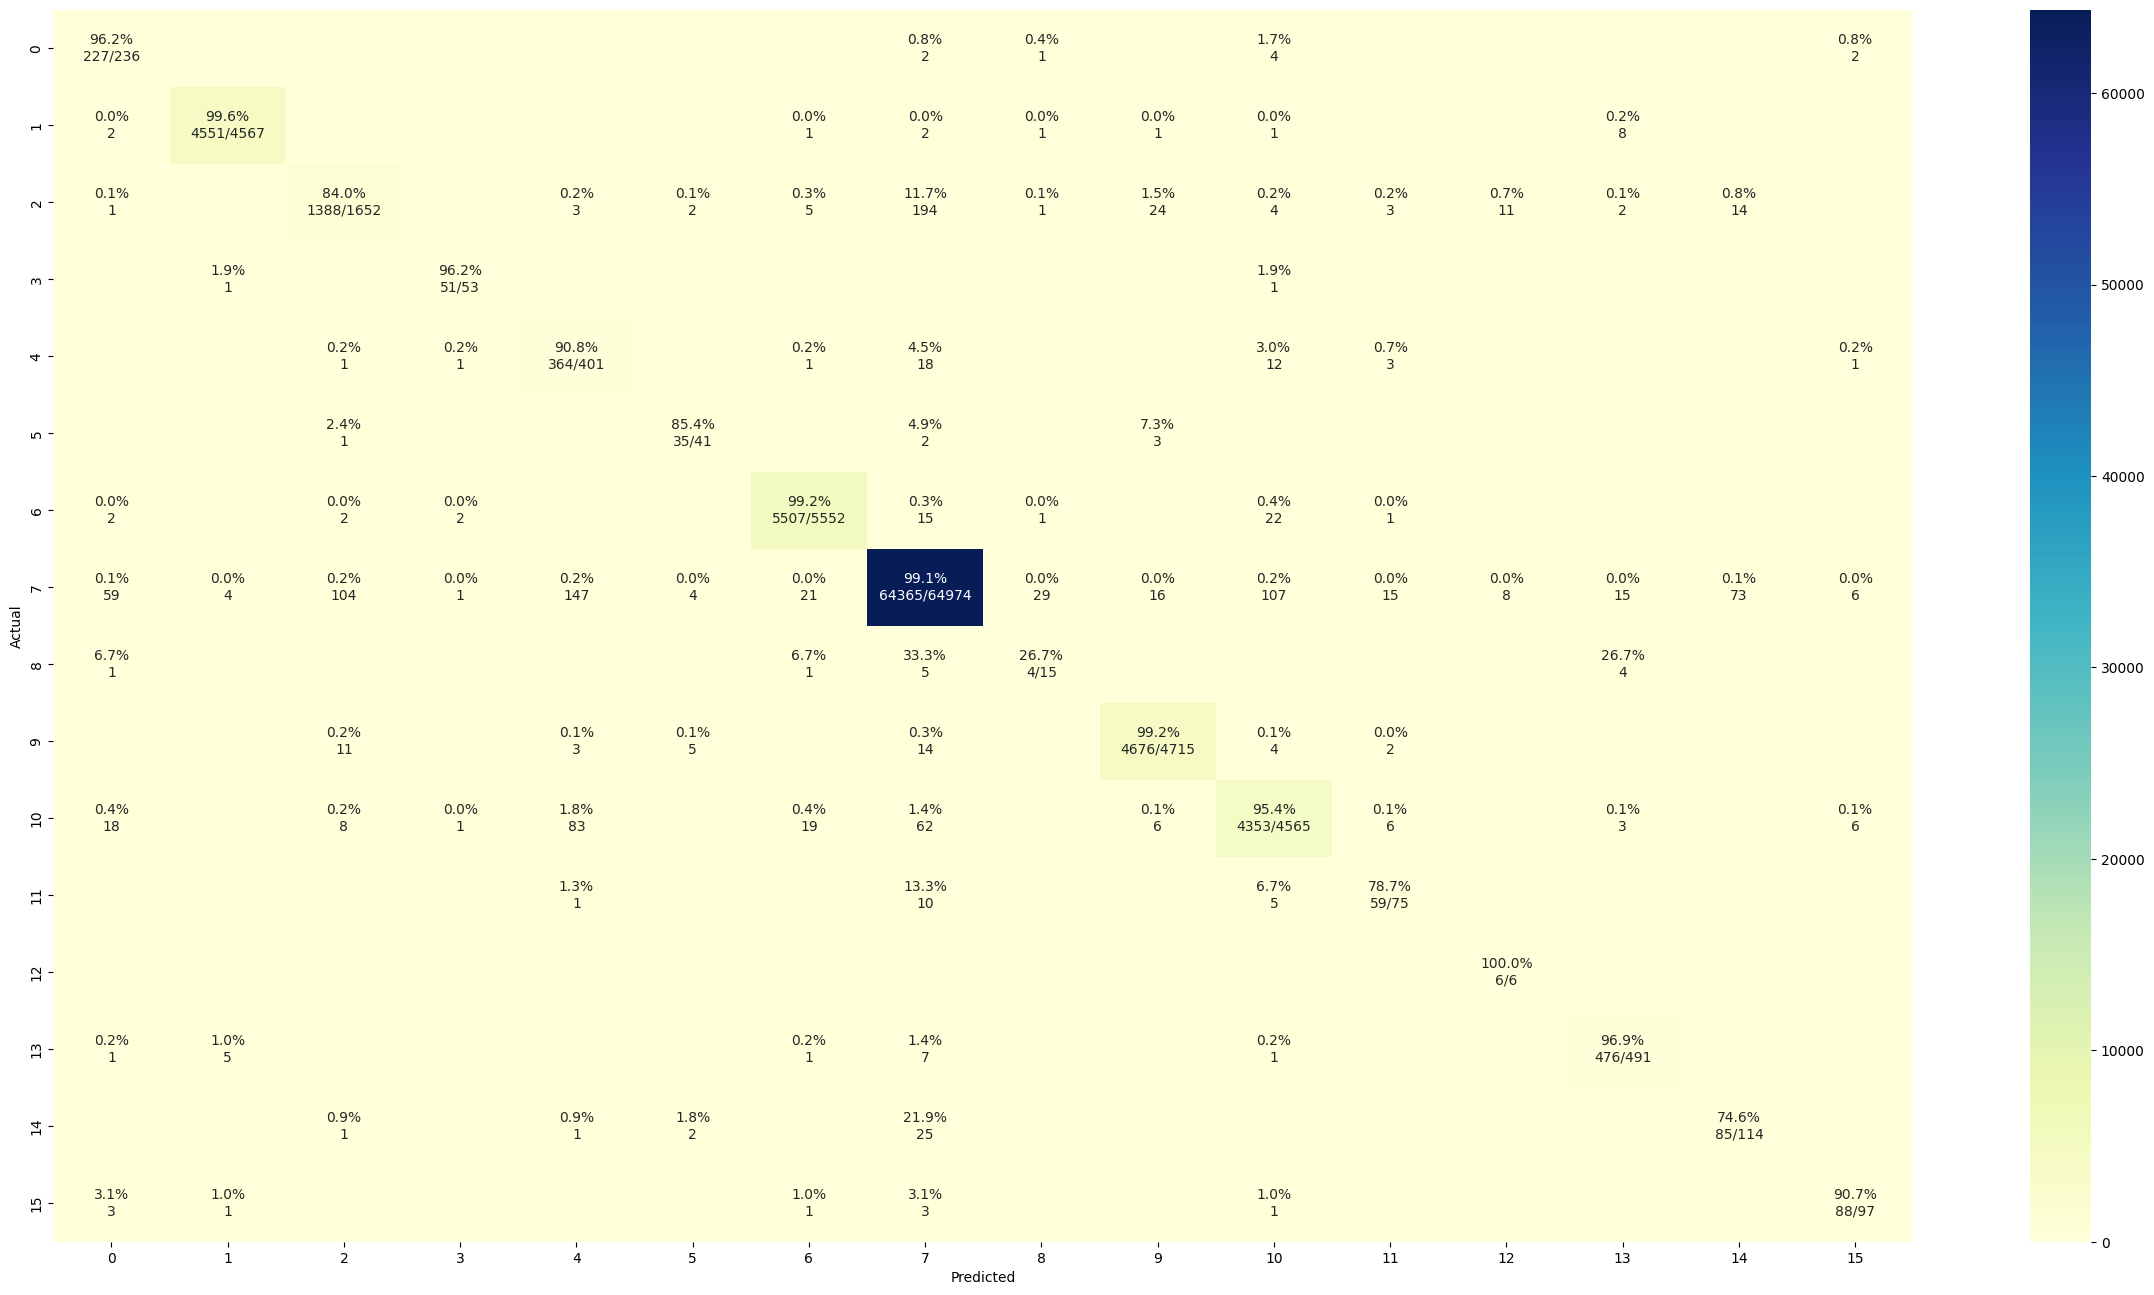

In [ ]:
plot_cm(y_test,y_pred1)

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred1))

Accuracy: 0.985


In [ ]:
print('F1 Score: %.3f' % f1_score(y_test, y_pred1, average='weighted'))


F1 Score: 0.986


In [ ]:
print('Recall: %.3f' % recall_score(y_test, y_pred1, average='weighted'))

Recall: 0.985


In [ ]:
print('Precision: %.3f' % precision_score(y_test, y_pred1, average='weighted'))

Precision: 0.987


## With Nadam, Mish

In [ ]:
from tensorflow.keras.optimizers.experimental import Nadam
opt = Nadam(learning_rate=0.001)

In [ ]:
model2= Sequential()

model2.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='Mish',input_shape=(216,1)))
model2.add(MaxPooling1D(pool_size=1))
model2.add(BatchNormalization())

model2.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='Mish'))
model2.add(MaxPooling1D(pool_size=1))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())

model2.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='Mish'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(BatchNormalization())


model2.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='Mish'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(Dense(128,activation='Mish'))
model2.add(Dropout(0.10))
model2.add(Dense(64,activation='Mish'))
model2.add(Dropout(0.10))
model2.add(Dense(16,activation='softmax'))

model2.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 216, 256)          1024      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 216, 256)         0         
 1D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 216, 256)         1024      
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 216, 128)          98432     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 216, 128)         0         
 1D)                                                             
                                                      

In [ ]:
checkpoint_path = 'mish_nadam.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
# from tensorflow.keras.utils import to_categorical

# y_train_encoded = to_categorical(y, num_classes=16)
# y_val_encoded = to_categorical(y_test3, num_classes=16)


In [ ]:
history2 = model2.fit(X_train2, y, 
                    epochs=100, 
                  batch_size=128, class_weight = new_dic, callbacks =[checkpoint_callback])

Epoch 1/100
175/177 [============================>.] - ETA: 0s - loss: 2.1846 - accuracy: 0.6934
Epoch 1: accuracy improved from -inf to 0.69409, saving model to mish_nadam.h5
177/177 [==============================] - 14s 32ms/step - loss: 2.1993 - accuracy: 0.6941
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 1.2699 - accuracy: 0.8064
Epoch 2: accuracy improved from 0.69409 to 0.80642, saving model to mish_nadam.h5
177/177 [==============================] - 6s 32ms/step - loss: 1.2699 - accuracy: 0.8064
Epoch 3/100
177/177 [==============================] - ETA: 0s - loss: 0.9906 - accuracy: 0.8470
Epoch 3: accuracy improved from 0.80642 to 0.84700, saving model to mish_nadam.h5
177/177 [==============================] - 6s 32ms/step - loss: 0.9906 - accuracy: 0.8470
Epoch 4/100
177/177 [==============================] - ETA: 0s - loss: 0.8127 - accuracy: 0.8685
Epoch 4: accuracy improved from 0.84700 to 0.86854, saving model to mish_nadam.h5
177/177 [=======

In [ ]:
model2.load_weights(checkpoint_path)

In [ ]:
y_pred2 = np.argmax(model2.predict(X_test2),axis=-1)

2737/2737 [==============================] - 8s 3ms/step


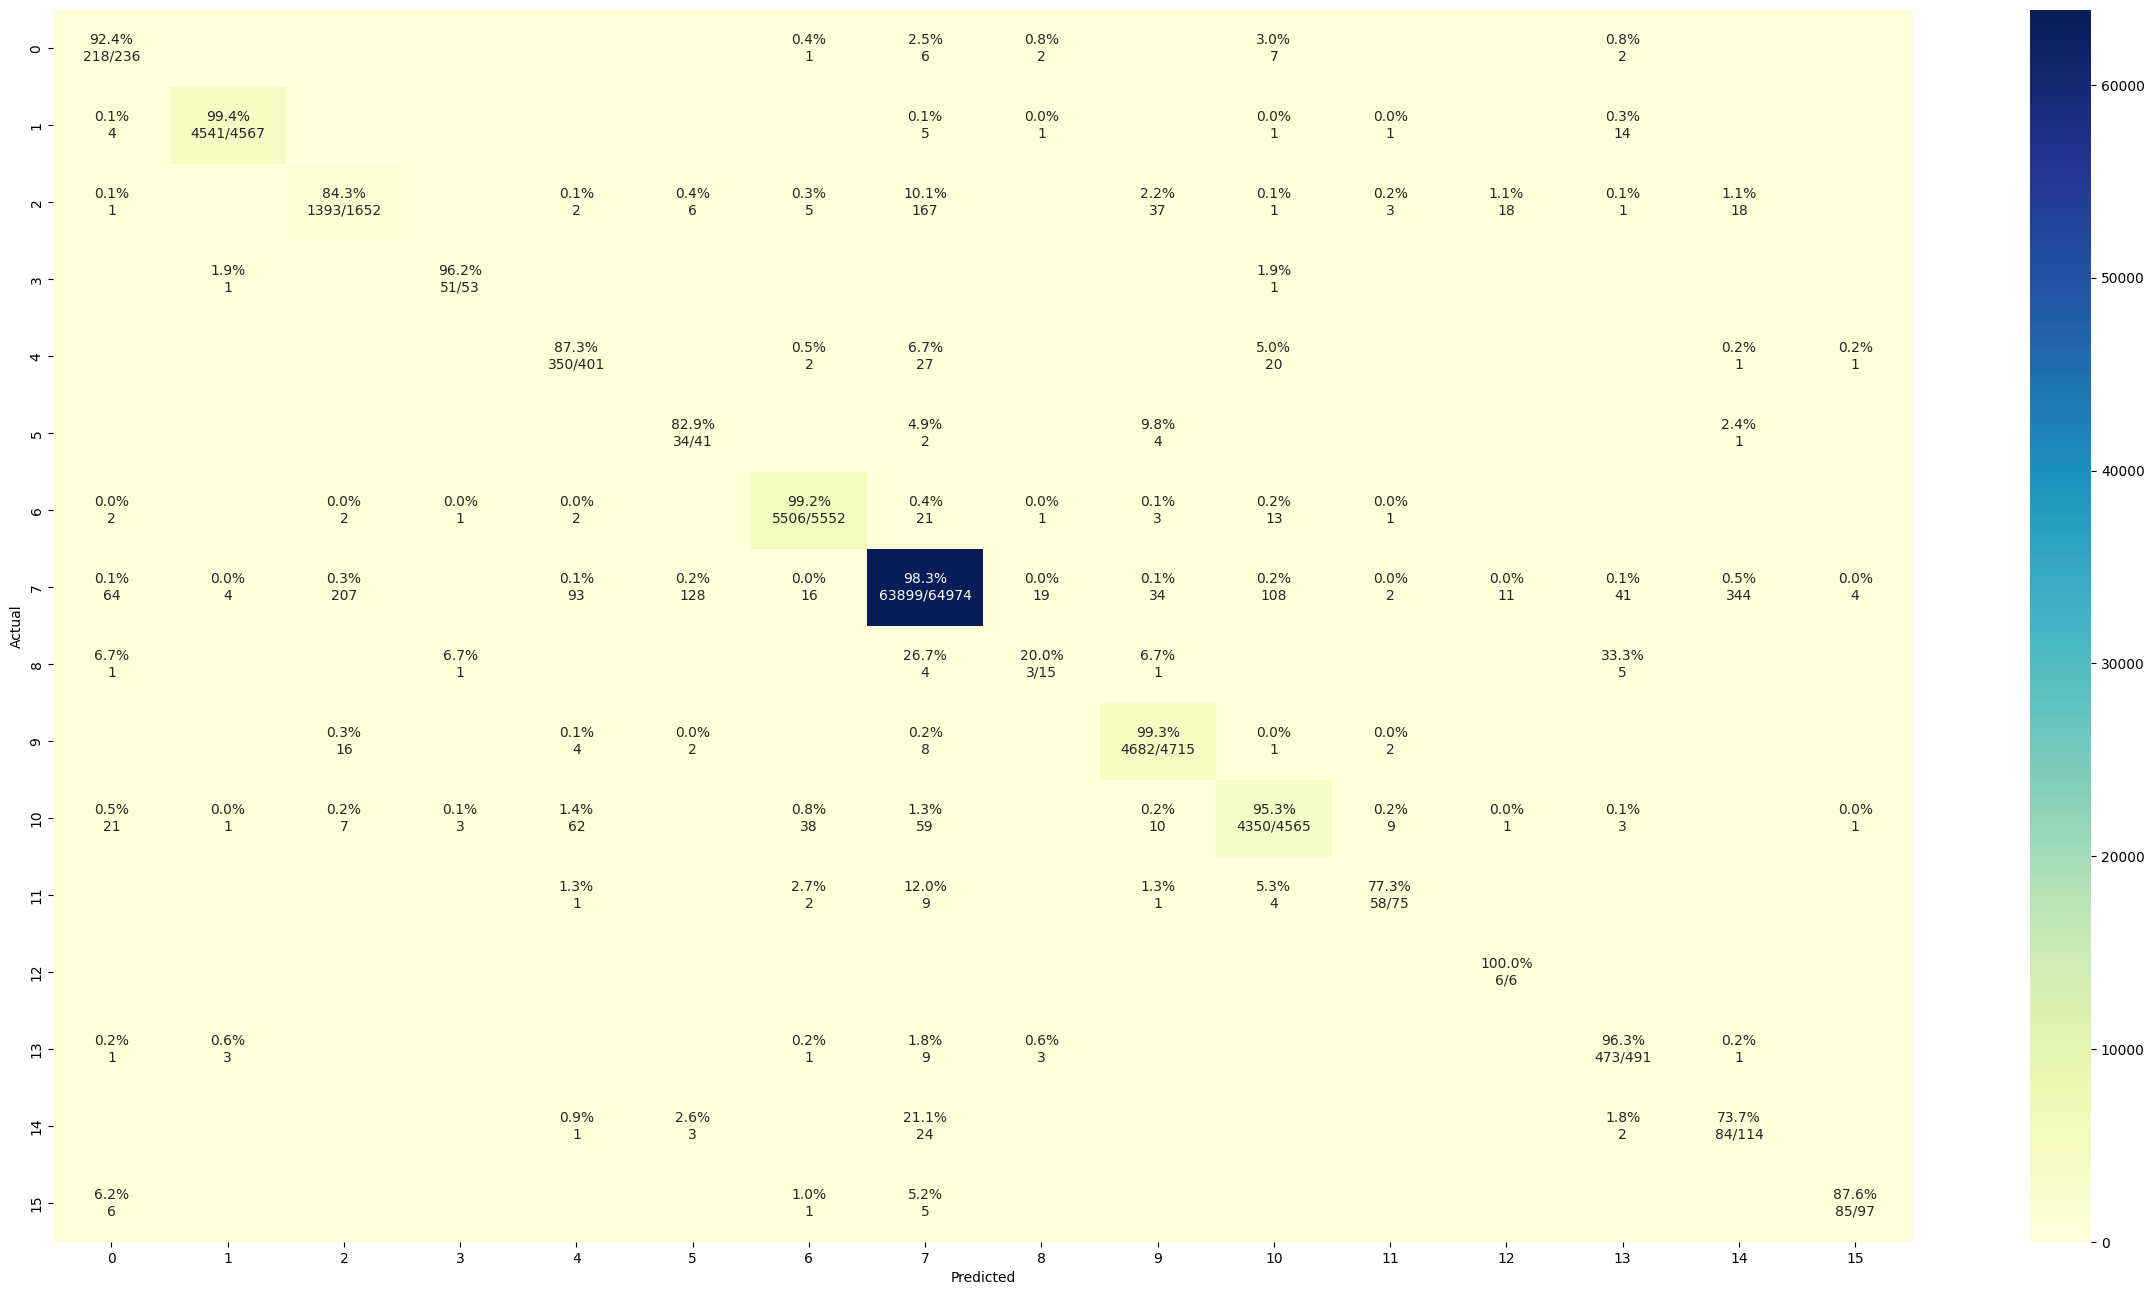

In [ ]:
plot_cm(y_test,y_pred2)

In [ ]:
print('Accuracy: %.5f' % accuracy_score(y_test, y_pred2))

Accuracy: 0.97920


In [ ]:
print('F1 Score: %.5f' % f1_score(y_test, y_pred2, average='weighted'))


F1 Score: 0.98145


In [ ]:
print('Recall: %.5f' % recall_score(y_test, y_pred2, average='weighted'))

Recall: 0.97920


In [ ]:
print('Precision: %.5f' % precision_score(y_test, y_pred2, average='weighted'))


Precision: 0.98464


## With Nadam, ReLu

In [ ]:
from tensorflow.keras.optimizers.experimental import Nadam
opt = Nadam(learning_rate=0.005)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv1D, GlobalMaxPooling1D,MaxPooling1D,GRU,Flatten,SpatialDropout1D,Bidirectional,LSTM
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation

model3= Sequential()

model3.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu',input_shape=(216,1)))
model3.add(MaxPooling1D(pool_size=1))
model3.add(BatchNormalization())

model3.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'))
model3.add(MaxPooling1D(pool_size=1))
model3.add(Dropout(0.25))
model3.add(BatchNormalization())

model3.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(BatchNormalization())


model3.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.25))
model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dense(128,activation='relu'))
model3.add(Dropout(0.10))
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.10))
model3.add(Dense(16,activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 216, 256)          1024      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 216, 256)         0         
 1D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 216, 256)         1024      
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, 216, 128)          98432     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 216, 128)         0         
 1D)                                                             
                                                      

In [ ]:
checkpoint_path = 'relu_nadam.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
history3 = model3.fit(X_train2, y, 
                    epochs=100, 
                    batch_size=128, class_weight = new_dic, callbacks =[checkpoint_callback])

Epoch 1/100
175/177 [============================>.] - ETA: 0s - loss: 2.5768 - accuracy: 0.6538
Epoch 1: accuracy improved from -inf to 0.65373, saving model to relu_nadam.h5
177/177 [==============================] - 11s 28ms/step - loss: 2.5734 - accuracy: 0.6537
Epoch 2/100
175/177 [============================>.] - ETA: 0s - loss: 2.0633 - accuracy: 0.7238
Epoch 2: accuracy improved from 0.65373 to 0.72449, saving model to relu_nadam.h5
177/177 [==============================] - 5s 27ms/step - loss: 2.0562 - accuracy: 0.7245
Epoch 3/100
175/177 [============================>.] - ETA: 0s - loss: 1.7337 - accuracy: 0.7423
Epoch 3: accuracy improved from 0.72449 to 0.74270, saving model to relu_nadam.h5
177/177 [==============================] - 5s 28ms/step - loss: 1.7280 - accuracy: 0.7427
Epoch 4/100
175/177 [============================>.] - ETA: 0s - loss: 1.3148 - accuracy: 0.8056
Epoch 4: accuracy improved from 0.74270 to 0.80420, saving model to relu_nadam.h5
177/177 [=======

In [ ]:
model3.load_weights(checkpoint_path)

In [ ]:
y_pred3 = np.argmax(model3.predict(X_test2),axis=-1)

2737/2737 [==============================] - 8s 3ms/step


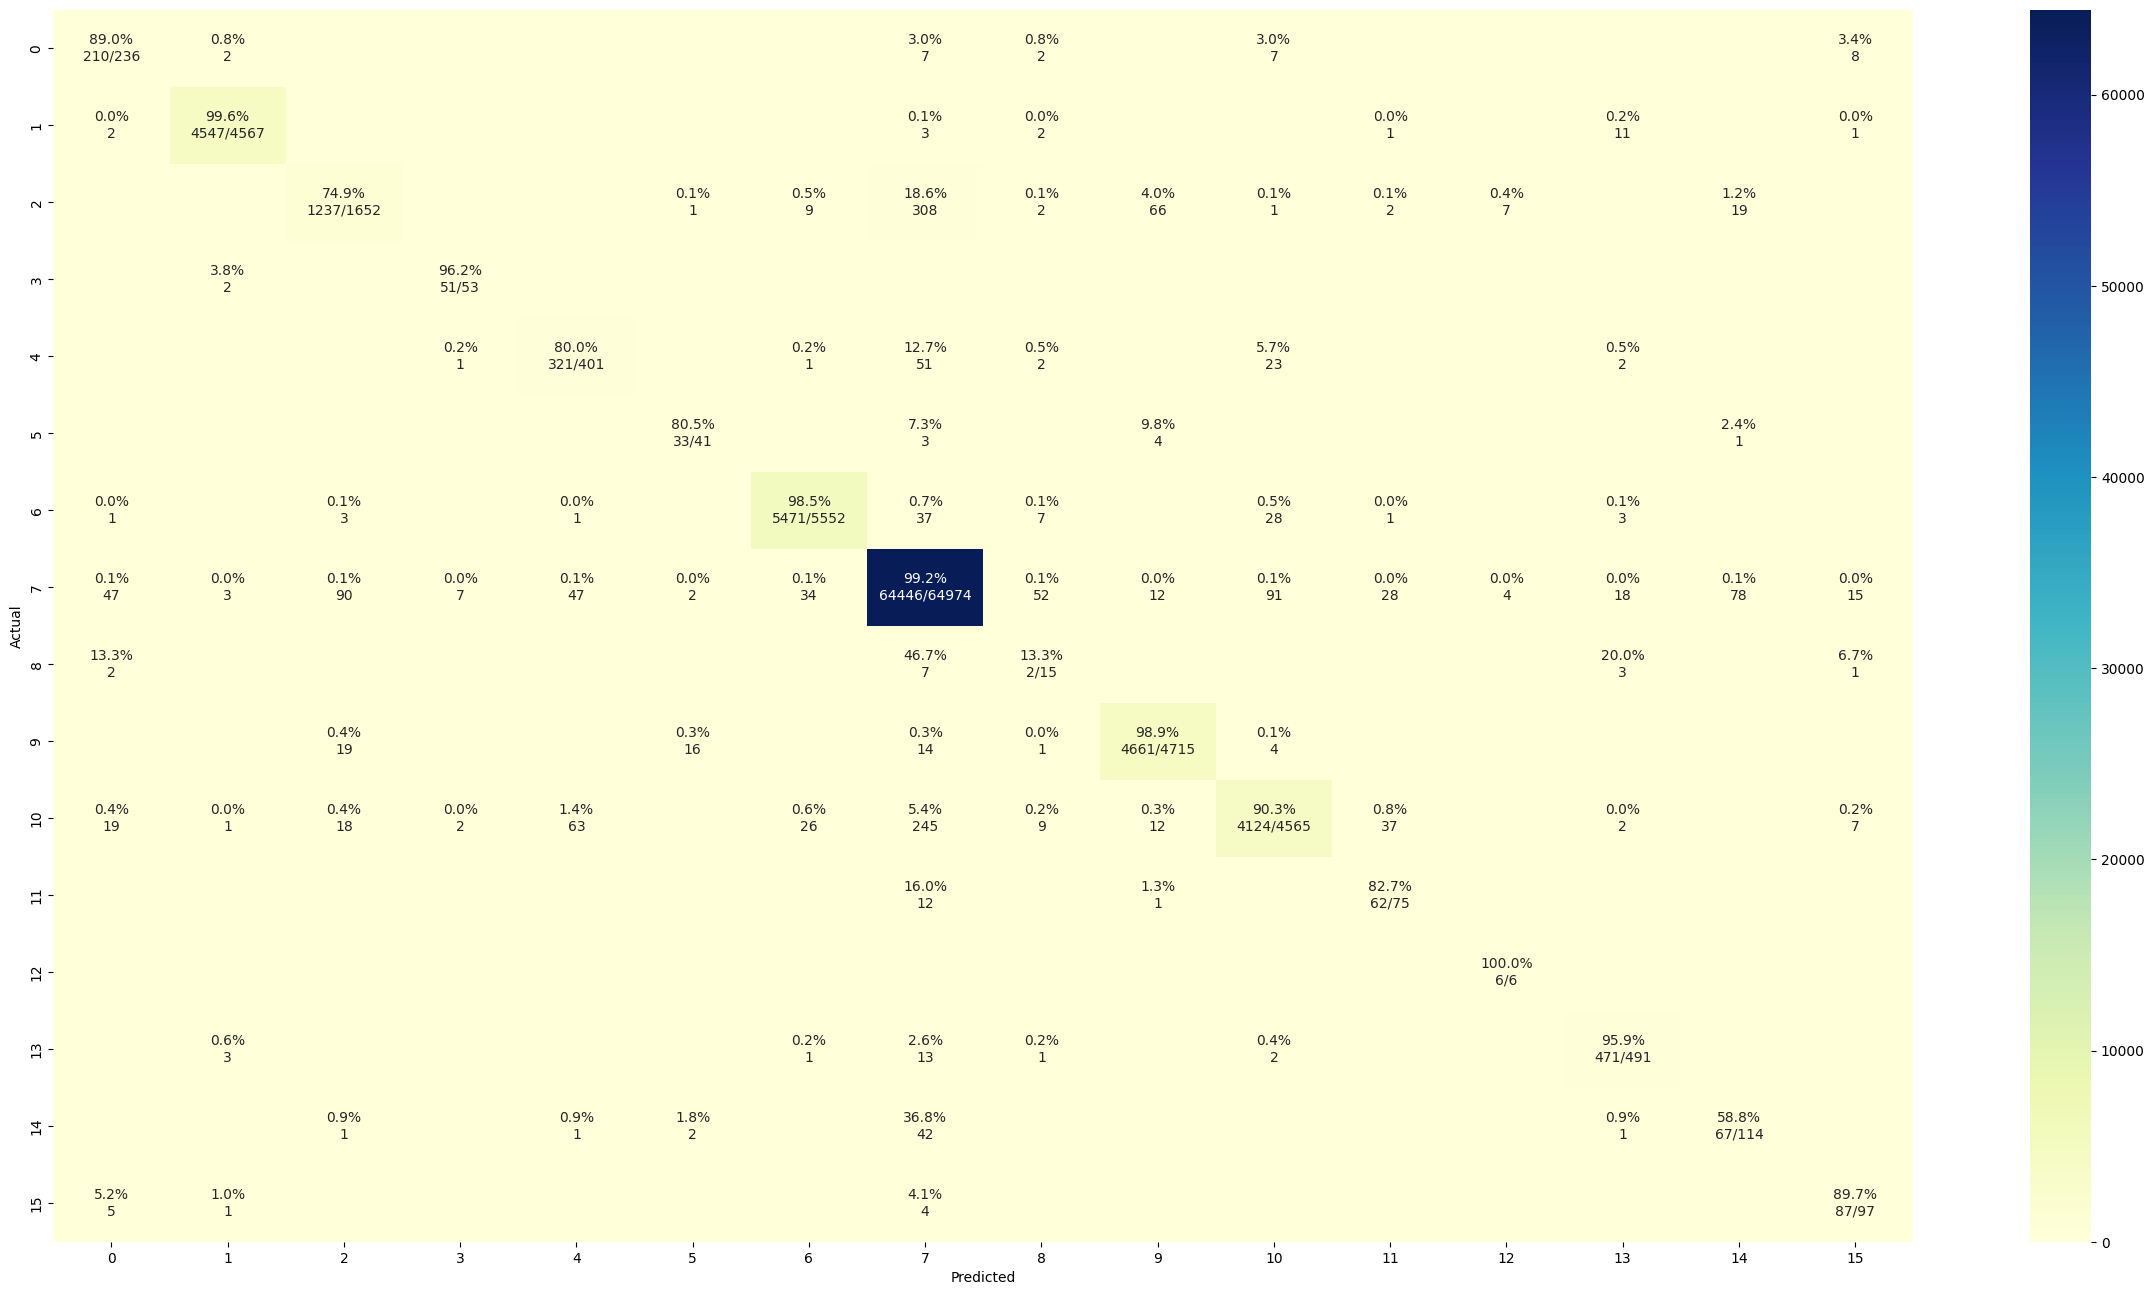

In [ ]:
plot_cm(y_test,y_pred3)

In [ ]:
print('Accuracy: %.5f' % accuracy_score(y_test, y_pred3))

Accuracy: 0.97992


In [ ]:
print('F1 Score: %.5f' % f1_score(y_test, y_pred3, average='weighted'))


F1 Score: 0.98035


In [ ]:
print('Recall: %.5f' % recall_score(y_test, y_pred3, average='weighted'))

Recall: 0.97992


In [ ]:
print('Precision: %.5f' % precision_score(y_test, y_pred3, average='weighted'))

Precision: 0.98142


## With Nadam, Swish

In [ ]:
from tensorflow.keras.optimizers.experimental import Nadam
opt = Nadam(learning_rate=0.001)

In [ ]:
model4= Sequential()

model4.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='swish',input_shape=(216,1)))
model4.add(MaxPooling1D(pool_size=1))
model4.add(BatchNormalization())

model4.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='swish'))
model4.add(MaxPooling1D(pool_size=1))
model4.add(Dropout(0.25))
model4.add(BatchNormalization())

model4.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='swish'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(BatchNormalization())


model4.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='swish'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.25))
model4.add(BatchNormalization())

model4.add(Flatten())

model4.add(Dense(128,activation='swish'))
model4.add(Dropout(0.10))
model4.add(Dense(64,activation='swish'))
model4.add(Dropout(0.10))
model4.add(Dense(16,activation='softmax'))
model4.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 216, 256)          1024      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 216, 256)         0         
 g1D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 216, 256)         1024      
 chNormalization)                                                
                                                                 
 conv1d_13 (Conv1D)          (None, 216, 128)          98432     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 216, 128)         0         
 g1D)                                                            
                                                      

In [ ]:
checkpoint_path = 'swish_nadam.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
history4 = model4.fit(X_train2, y, 
                    epochs=100, 
                    batch_size=128, class_weight = new_dic,callbacks =[checkpoint_callback] )

Epoch 1/100
175/177 [============================>.] - ETA: 0s - loss: 2.2531 - accuracy: 0.6952
Epoch 1: accuracy improved from -inf to 0.69542, saving model to swish_nadam.h5
177/177 [==============================] - 11s 31ms/step - loss: 2.2460 - accuracy: 0.6954
Epoch 2/100
175/177 [============================>.] - ETA: 0s - loss: 1.2534 - accuracy: 0.8227
Epoch 2: accuracy improved from 0.69542 to 0.82259, saving model to swish_nadam.h5
177/177 [==============================] - 5s 31ms/step - loss: 1.2644 - accuracy: 0.8226
Epoch 3/100
175/177 [============================>.] - ETA: 0s - loss: 0.9585 - accuracy: 0.8524
Epoch 3: accuracy improved from 0.82259 to 0.85250, saving model to swish_nadam.h5
177/177 [==============================] - 6s 31ms/step - loss: 0.9571 - accuracy: 0.8525
Epoch 4/100
175/177 [============================>.] - ETA: 0s - loss: 0.7257 - accuracy: 0.8821
Epoch 4: accuracy improved from 0.85250 to 0.88209, saving model to swish_nadam.h5
177/177 [===

In [ ]:
model4.load_weights(checkpoint_path)

In [ ]:
y_pred4 = np.argmax(model4.predict(X_test2),axis=-1)

2737/2737 [==============================] - 8s 3ms/step


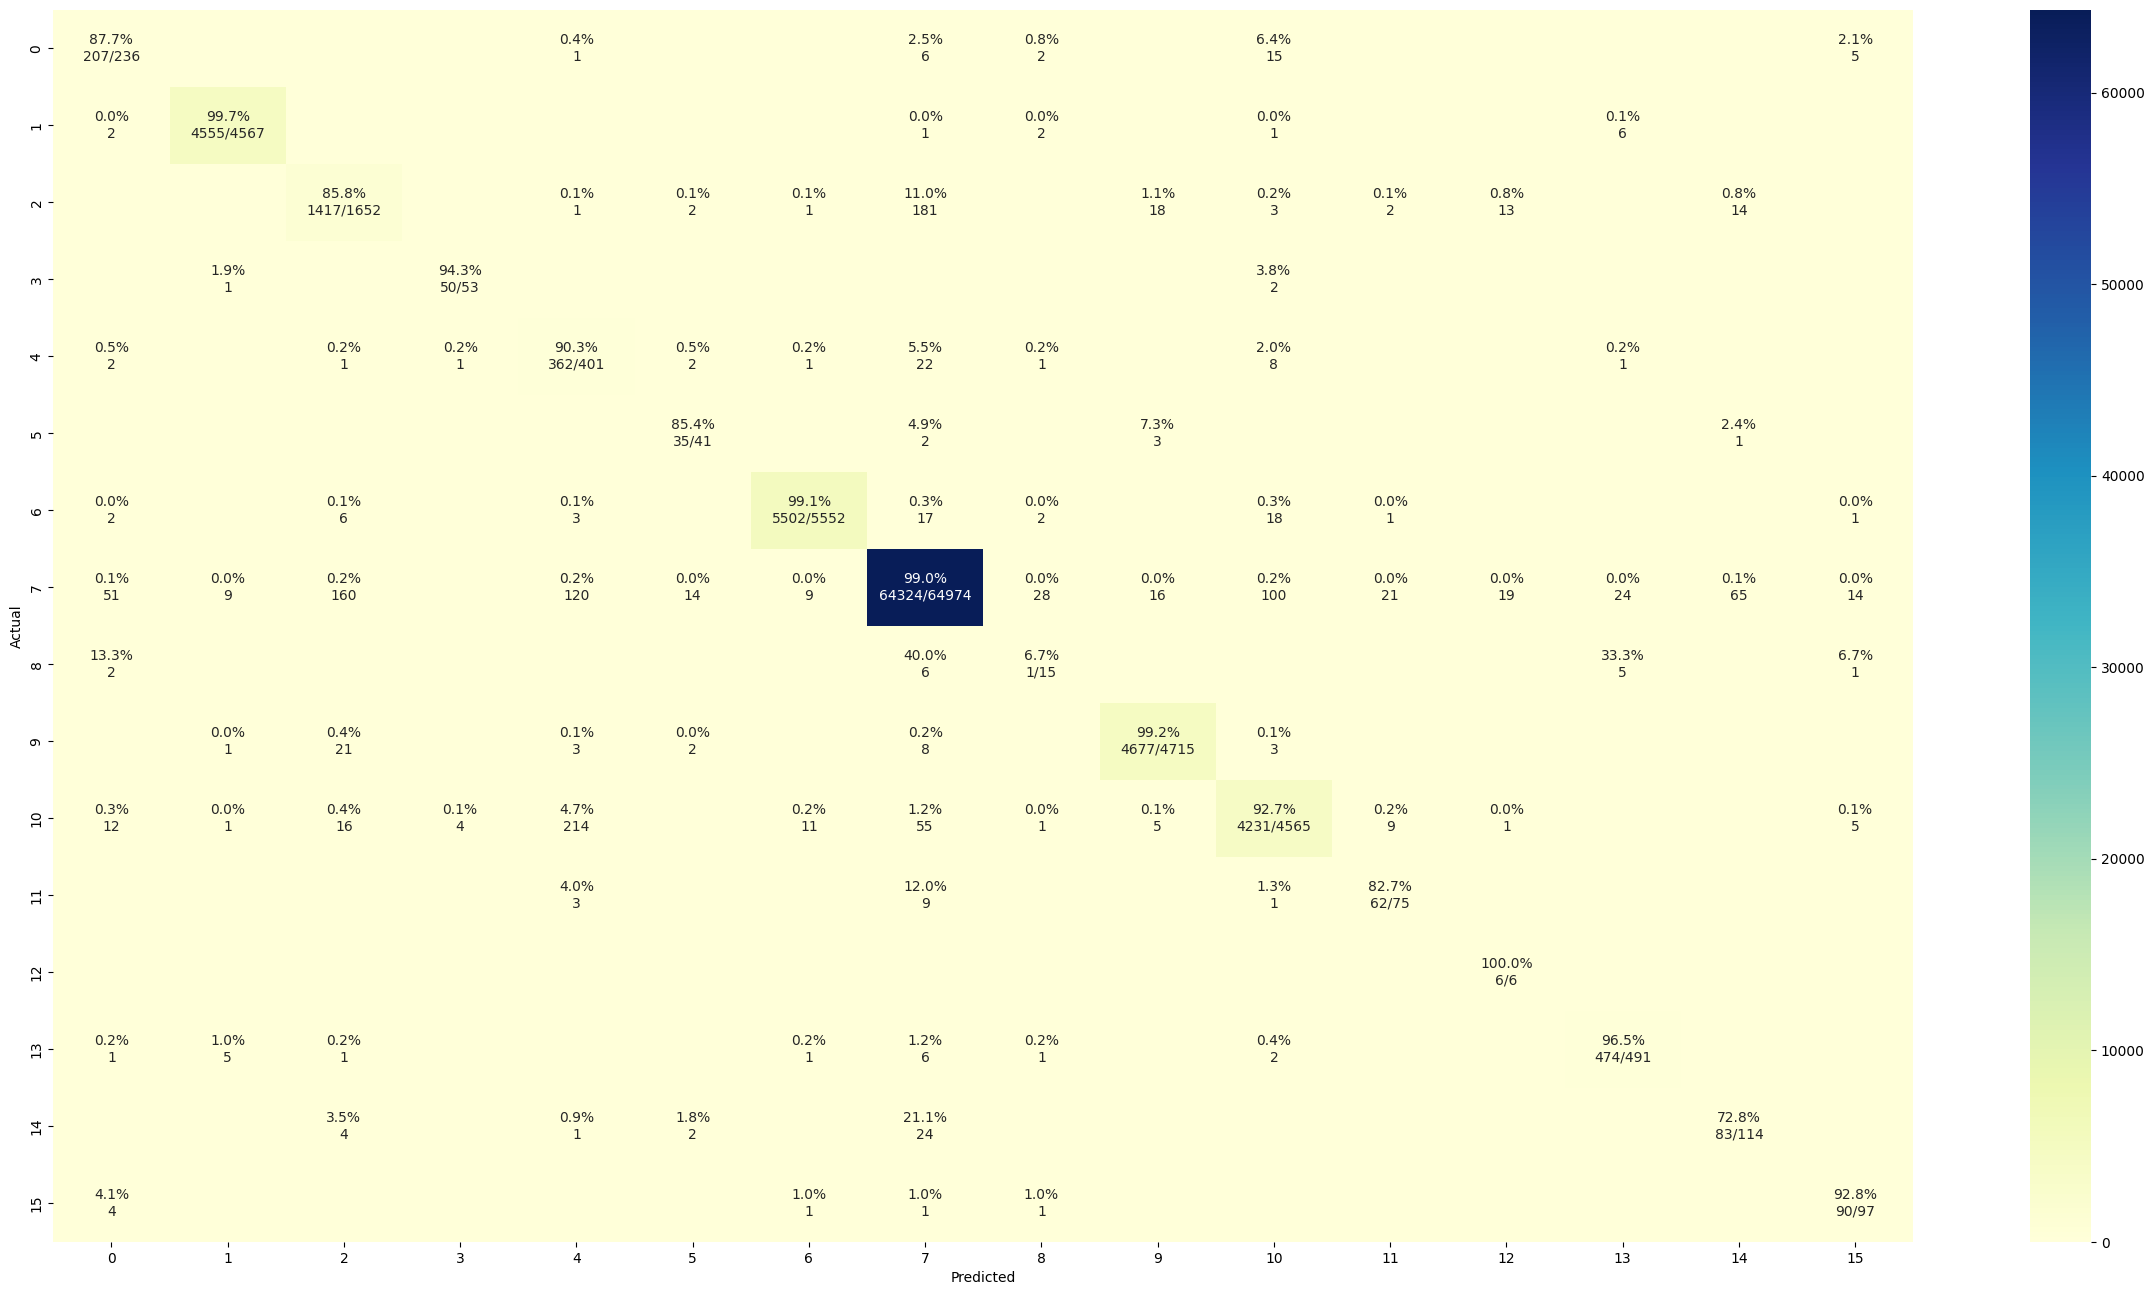

In [ ]:
plot_cm(y_test,y_pred4)

In [ ]:
print('Accuracy: %.5f' % accuracy_score(y_test, y_pred4))

Accuracy: 0.98312


In [ ]:

print('F1 Score: %.5f' % f1_score(y_test, y_pred4, average='weighted'))


F1 Score: 0.98415


In [ ]:
print('Recall: %.5f' % recall_score(y_test, y_pred4, average='weighted'))

Recall: 0.98312


In [ ]:
print('Precision: %.5f' % precision_score(y_test, y_pred4, average='weighted'))


Precision: 0.98592


## Adam, ReLu

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

In [ ]:
model5= Sequential()

model5.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu',input_shape=(216,1)))
model5.add(MaxPooling1D(pool_size=1))
model5.add(BatchNormalization())

model5.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'))
model5.add(MaxPooling1D(pool_size=1))
model5.add(Dropout(0.25))
model5.add(BatchNormalization())

model5.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(BatchNormalization())


model5.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Dropout(0.25))
model5.add(BatchNormalization())

model5.add(Flatten())

model5.add(Dense(128,activation='relu'))
model5.add(Dropout(0.10))
model5.add(Dense(64,activation='relu'))
model5.add(Dropout(0.10))
model5.add(Dense(16,activation='softmax'))
model5.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 216, 256)          1024      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 216, 256)         0         
 g1D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 216, 256)         1024      
 chNormalization)                                                
                                                                 
 conv1d_17 (Conv1D)          (None, 216, 128)          98432     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 216, 128)         0         
 g1D)                                                            
                                                      

In [ ]:
checkpoint_path = 'relu_adam.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
history5 = model5.fit(X_train2, y, 
                    epochs=100, 
                    batch_size=128, class_weight = new_dic, callbacks =[checkpoint_callback])

Epoch 1/100
175/177 [============================>.] - ETA: 0s - loss: 2.4522 - accuracy: 0.6573
Epoch 1: accuracy improved from -inf to 0.65776, saving model to relu_adam.h5
177/177 [==============================] - 6s 25ms/step - loss: 2.4474 - accuracy: 0.6578
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 1.4250 - accuracy: 0.7916
Epoch 2: accuracy improved from 0.65776 to 0.79162, saving model to relu_adam.h5
177/177 [==============================] - 4s 25ms/step - loss: 1.4250 - accuracy: 0.7916
Epoch 3/100
175/177 [============================>.] - ETA: 0s - loss: 1.1171 - accuracy: 0.8378
Epoch 3: accuracy improved from 0.79162 to 0.83819, saving model to relu_adam.h5
177/177 [==============================] - 4s 25ms/step - loss: 1.1135 - accuracy: 0.8382
Epoch 4/100
175/177 [============================>.] - ETA: 0s - loss: 0.8098 - accuracy: 0.8708
Epoch 4: accuracy improved from 0.83819 to 0.87066, saving model to relu_adam.h5
177/177 [============

In [ ]:
model5.load_weights(checkpoint_path)

In [ ]:
y_pred5 = np.argmax(model5.predict(X_test2),axis=-1)

2737/2737 [==============================] - 8s 3ms/step


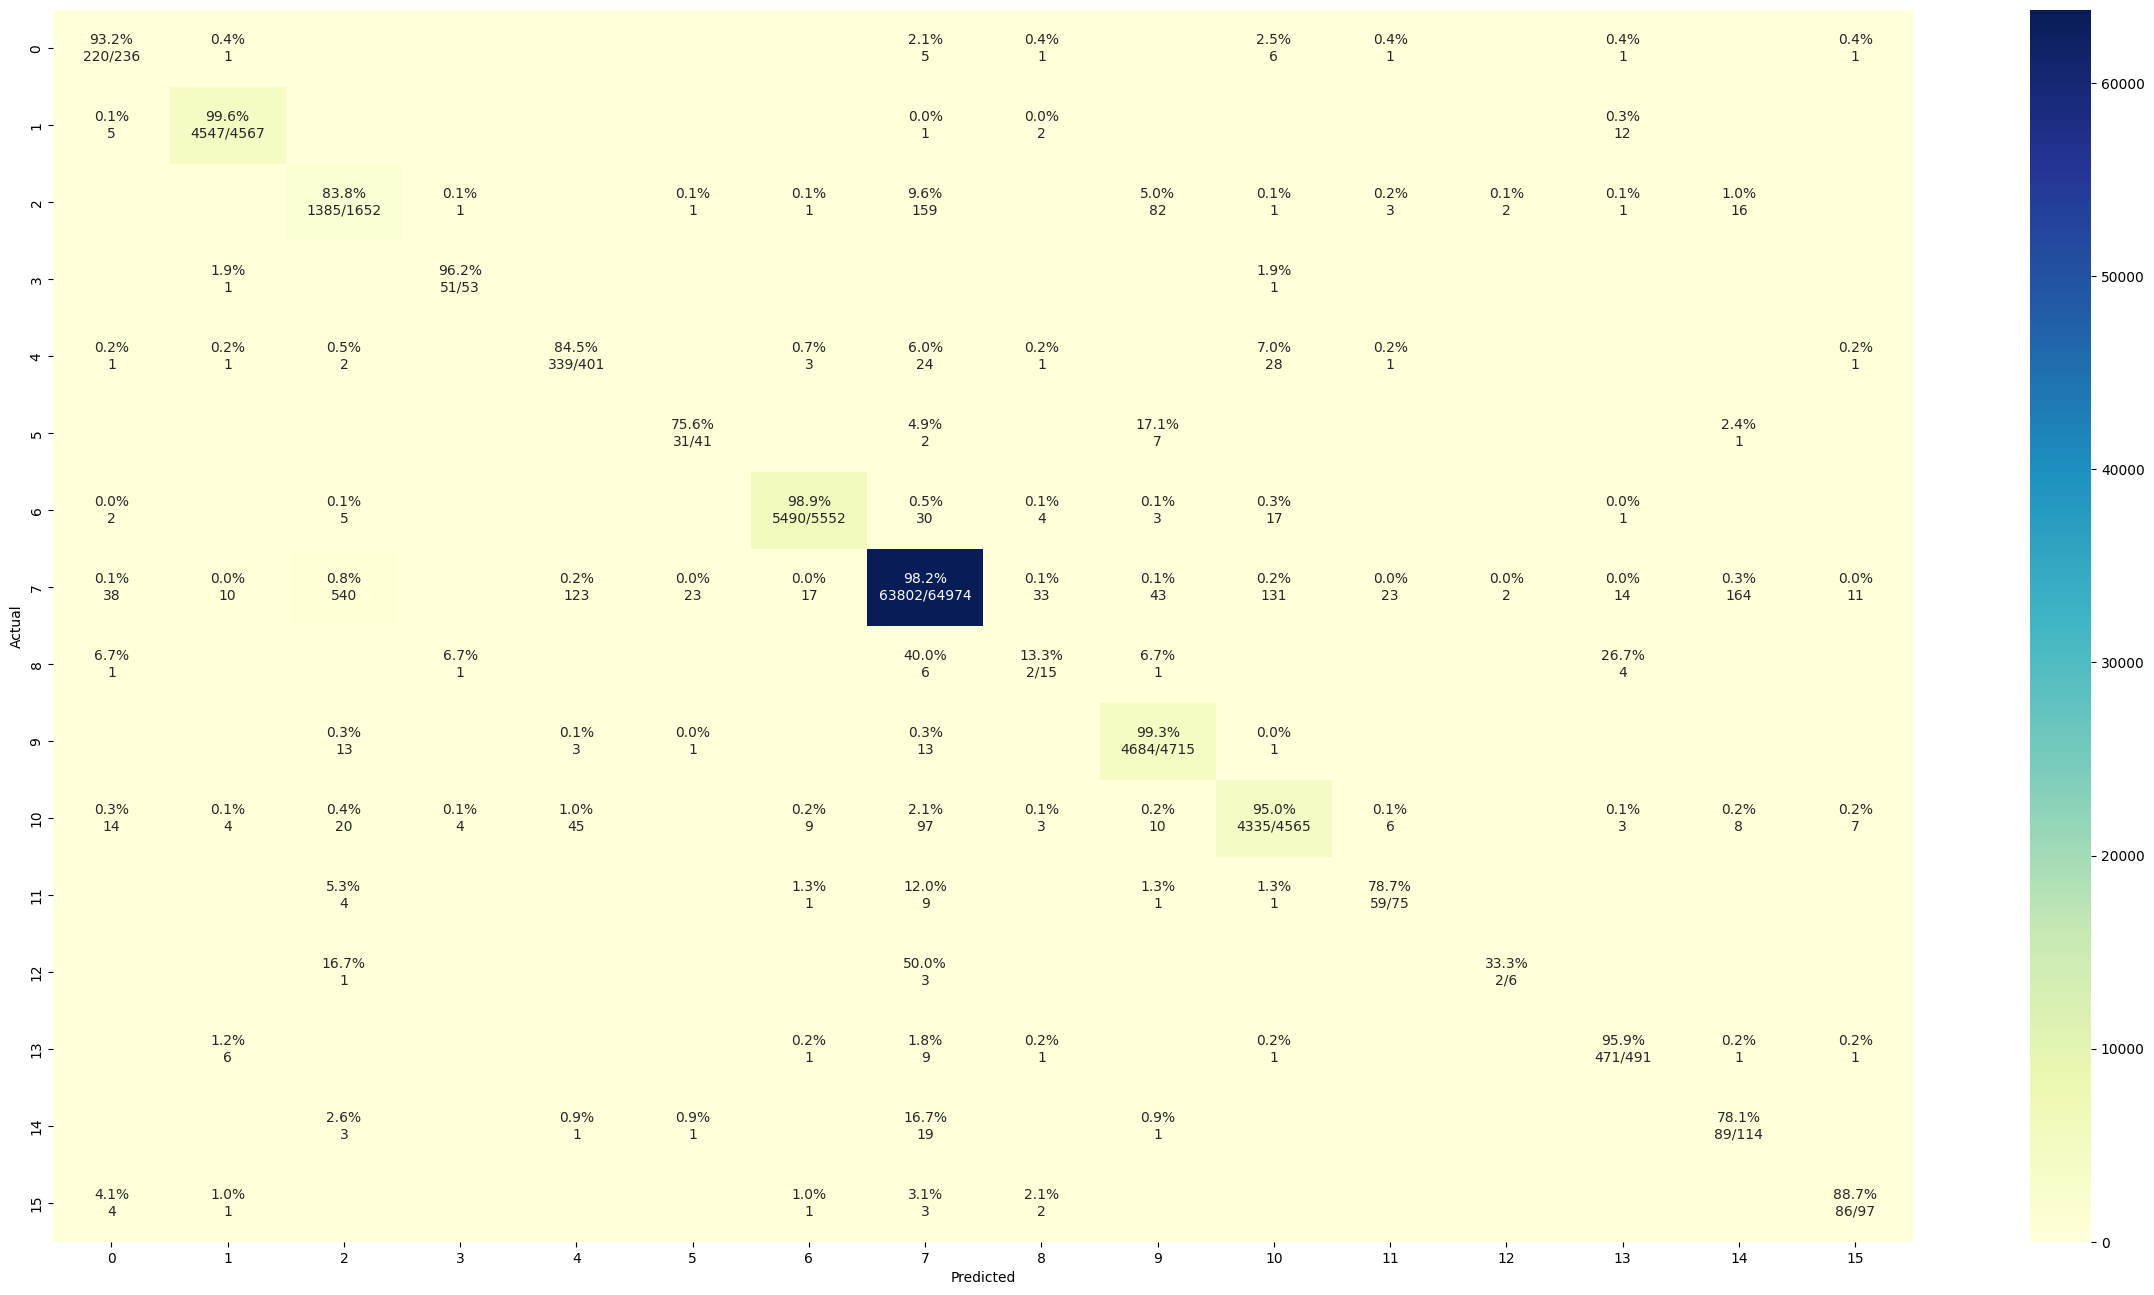

In [ ]:
plot_cm(y_test,y_pred5)

In [ ]:
print('Accuracy: %.5f' % accuracy_score(y_test, y_pred5))

Accuracy: 0.97760


In [ ]:
print('F1 Score: %.5f' % f1_score(y_test, y_pred5, average='weighted'))


F1 Score: 0.97896


In [ ]:
print('Recall: %.5f' % recall_score(y_test, y_pred5, average='weighted'))

Recall: 0.97760


In [ ]:
print('Precision: %.5f' % precision_score(y_test, y_pred5, average='weighted'))


Precision: 0.98107


## Adam, Swish

In [ ]:
from tensorflow.keras.layers import SeparableConv1D

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

In [ ]:
model6= Sequential()

model6.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='swish',input_shape=(216,1)))
model6.add(MaxPooling1D(pool_size=1))
model6.add(BatchNormalization())

model6.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='swish'))
model6.add(MaxPooling1D(pool_size=1))
model6.add(Dropout(0.25))
model6.add(BatchNormalization())

model6.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='swish'))
model6.add(MaxPooling1D(pool_size=2))
model6.add(BatchNormalization())


model6.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='swish'))
model6.add(MaxPooling1D(pool_size=2))
model6.add(Dropout(0.25))
model6.add(BatchNormalization())

model6.add(Flatten())

model6.add(Dense(128,activation='swish'))
model6.add(Dropout(0.10))
model6.add(Dense(64,activation='swish'))
model6.add(Dropout(0.10))
model6.add(Dense(16,activation='softmax'))
model6.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 216, 256)          1024      
                                                                 
 separable_conv1d_4 (Separab  (None, 214, 256)         66560     
 leConv1D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 214, 256)         1024      
 hNormalization)                                                 
                                                                 
 separable_conv1d_5 (Separab  (None, 210, 128)         34176     
 leConv1D)                                                       
                                                                 
 conv1d_5 (Conv1D)           (None, 210, 128)          49280     
                                                      

In [ ]:
checkpoint_path = 'swish_adam.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
history6 = model6.fit(X_train2, y, 
                    epochs=100, 
                    batch_size=128, class_weight = new_dic, callbacks =[checkpoint_callback])

Epoch 1/100
177/177 [==============================] - ETA: 0s - loss: 2.7302 - accuracy: 0.6173
Epoch 1: accuracy improved from -inf to 0.61731, saving model to swish_adam.h5
177/177 [==============================] - 19s 44ms/step - loss: 2.7302 - accuracy: 0.6173
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 1.6915 - accuracy: 0.7563
Epoch 2: accuracy improved from 0.61731 to 0.75626, saving model to swish_adam.h5
177/177 [==============================] - 7s 37ms/step - loss: 1.6915 - accuracy: 0.7563
Epoch 3/100
177/177 [==============================] - ETA: 0s - loss: 1.2666 - accuracy: 0.8099
Epoch 3: accuracy improved from 0.75626 to 0.80987, saving model to swish_adam.h5
177/177 [==============================] - 7s 37ms/step - loss: 1.2666 - accuracy: 0.8099
Epoch 4/100
177/177 [==============================] - ETA: 0s - loss: 1.0652 - accuracy: 0.8303
Epoch 4: accuracy improved from 0.80987 to 0.83025, saving model to swish_adam.h5
177/177 [=======

In [ ]:
model6.load_weights(checkpoint_path)

In [ ]:
y_pred6 = np.argmax(model6.predict(X_test2),axis=-1)

2737/2737 [==============================] - 10s 4ms/step


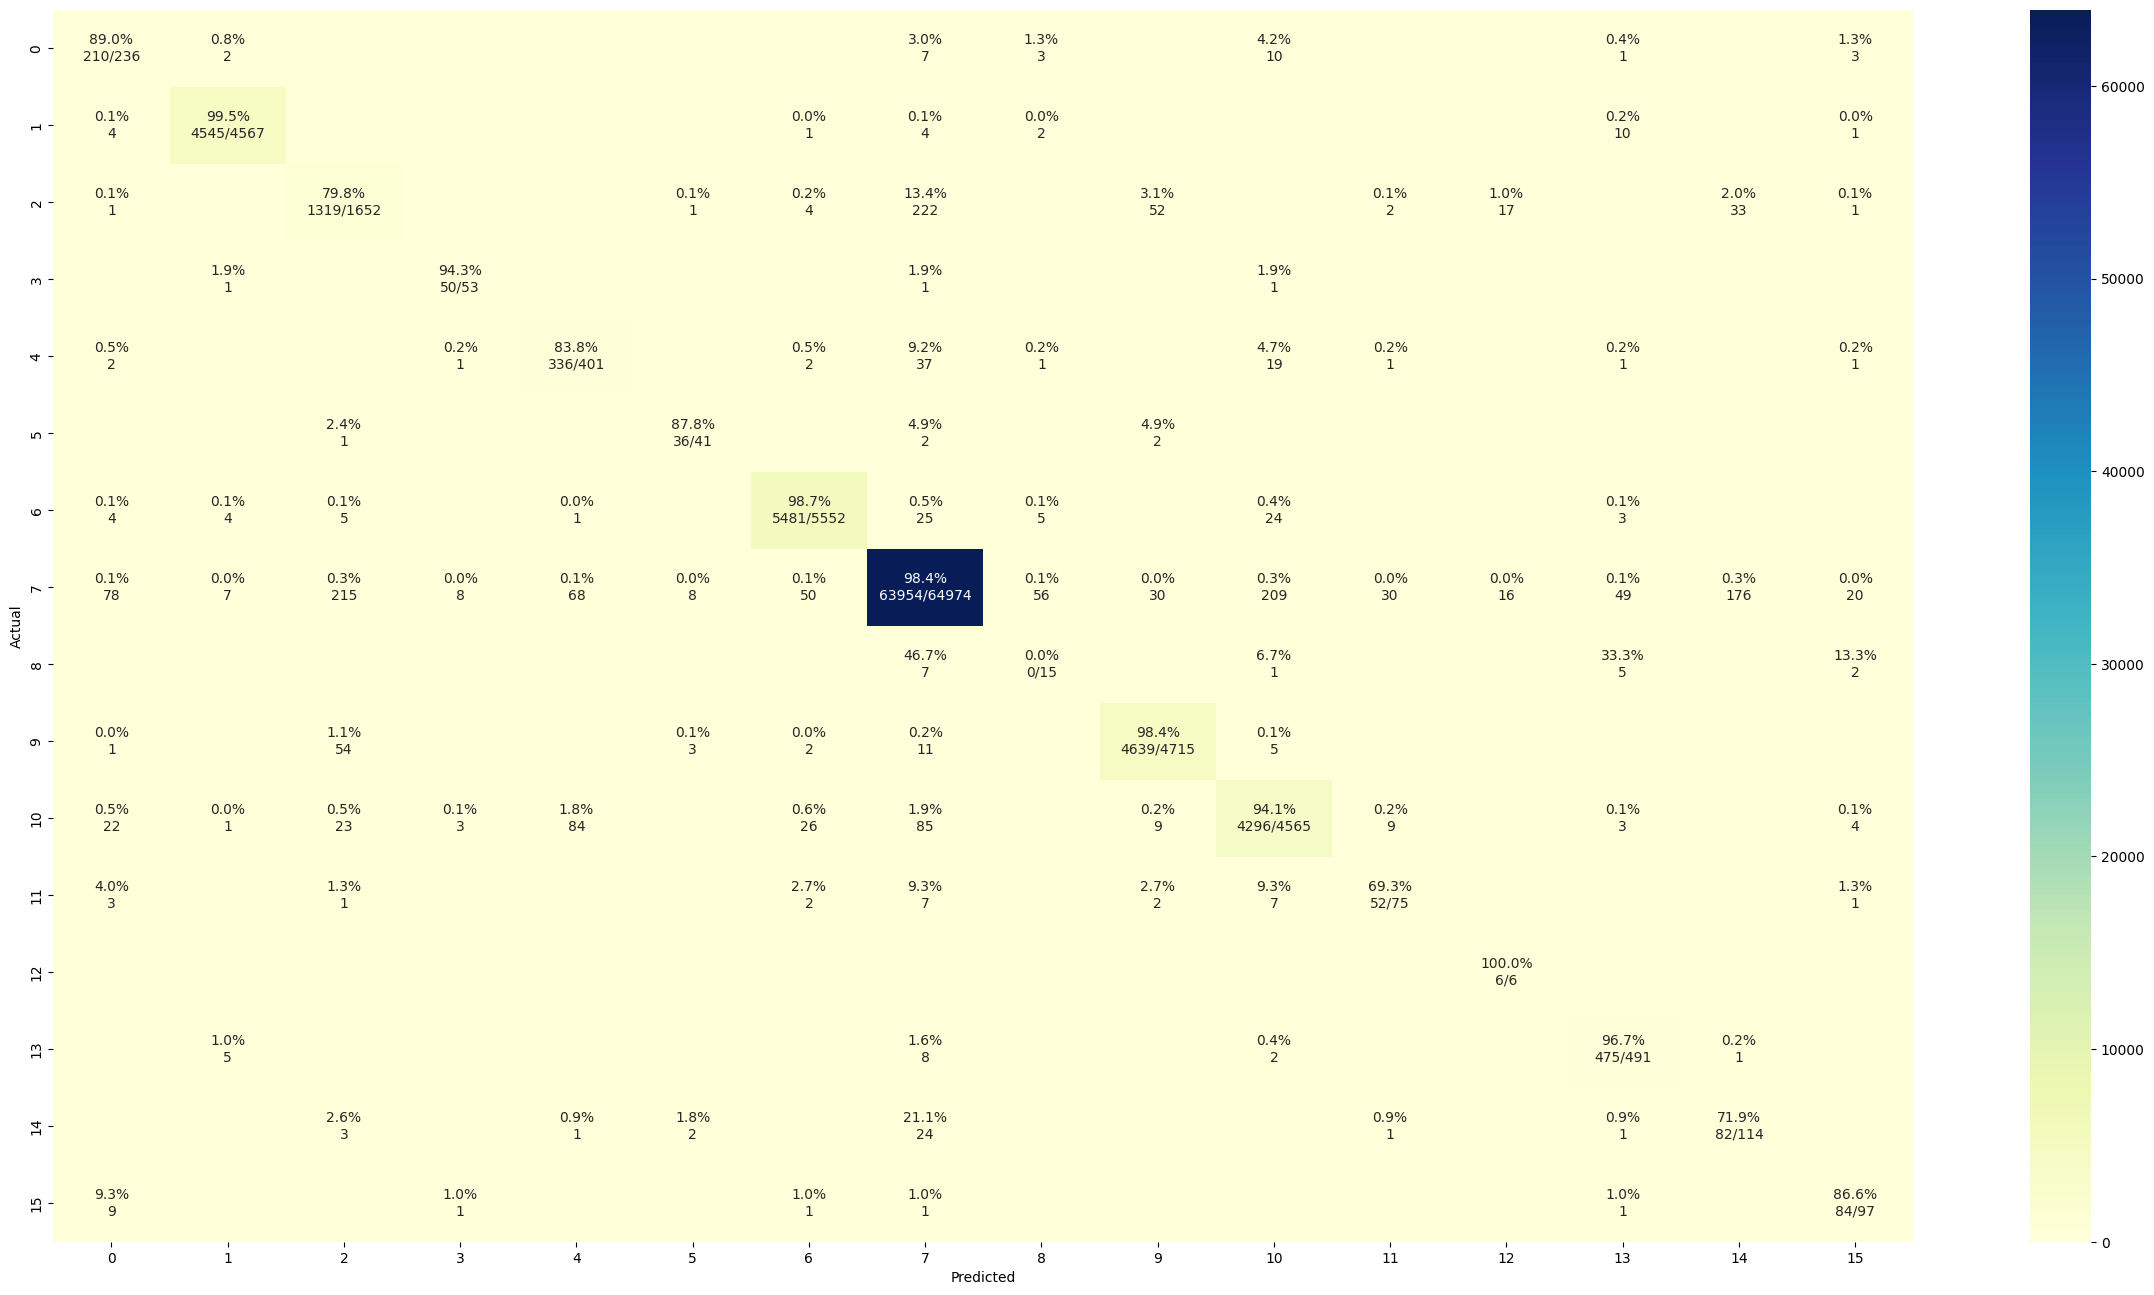

In [ ]:
plot_cm(y_test,y_pred6)

In [ ]:
print('Accuracy: %.5f' % accuracy_score(y_test, y_pred6))

Accuracy: 0.97728


In [ ]:
print('F1 Score: %.5f' % f1_score(y_test, y_pred6, average='weighted'))


F1 Score: 0.97865


In [ ]:
print('Recall: %.5f' % recall_score(y_test, y_pred6, average='weighted'))

Recall: 0.97728


In [ ]:
print('Precision: %.5f' % precision_score(y_test, y_pred6, average='weighted'))


Precision: 0.98060


## SGD,swish

In [ ]:
from tensorflow.keras.optimizers.experimental import SGD

In [ ]:
opt = SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
model7= Sequential()

model7.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='swish',input_shape=(216,1)))
model7.add(MaxPooling1D(pool_size=1))
model7.add(BatchNormalization())

model7.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='swish'))
model7.add(MaxPooling1D(pool_size=1))
model7.add(Dropout(0.25))
model7.add(BatchNormalization())

model7.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='swish'))
model7.add(MaxPooling1D(pool_size=2))
model7.add(BatchNormalization())


model7.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='swish'))
model7.add(MaxPooling1D(pool_size=2))
model7.add(Dropout(0.25))
model7.add(BatchNormalization())

model7.add(Flatten())

model7.add(Dense(128,activation='swish'))
model7.add(Dropout(0.10))
model7.add(Dense(64,activation='swish'))
model7.add(Dropout(0.10))
model7.add(Dense(16,activation='softmax'))
model7.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 216, 256)          1024      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 216, 256)         0         
 g1D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 216, 256)         1024      
 chNormalization)                                                
                                                                 
 conv1d_25 (Conv1D)          (None, 216, 128)          98432     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 216, 128)         0         
 g1D)                                                            
                                                      

In [ ]:
checkpoint_path = 'swish_sgd.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
history7 = model7.fit(X_train2, y, 
                    epochs=100, 
                    batch_size=128, class_weight = new_dic, callbacks =[checkpoint_callback])

Epoch 1/100
175/177 [============================>.] - ETA: 0s - loss: 2.8723 - accuracy: 0.5738
Epoch 1: accuracy improved from -inf to 0.57477, saving model to swish_sgd.h5
177/177 [==============================] - 9s 30ms/step - loss: 2.8662 - accuracy: 0.5748
Epoch 2/100
175/177 [============================>.] - ETA: 0s - loss: 1.6459 - accuracy: 0.7470
Epoch 2: accuracy improved from 0.57477 to 0.74753, saving model to swish_sgd.h5
177/177 [==============================] - 5s 29ms/step - loss: 1.6450 - accuracy: 0.7475
Epoch 3/100
175/177 [============================>.] - ETA: 0s - loss: 1.2380 - accuracy: 0.8045
Epoch 3: accuracy improved from 0.74753 to 0.80469, saving model to swish_sgd.h5
177/177 [==============================] - 5s 30ms/step - loss: 1.2347 - accuracy: 0.8047
Epoch 4/100
177/177 [==============================] - ETA: 0s - loss: 1.1227 - accuracy: 0.8348
Epoch 4: accuracy improved from 0.80469 to 0.83477, saving model to swish_sgd.h5
177/177 [============

In [ ]:
model7.load_weights(checkpoint_path)

In [ ]:
y_pred7 = np.argmax(model7.predict(X_test2),axis=-1)

2737/2737 [==============================] - 8s 3ms/step


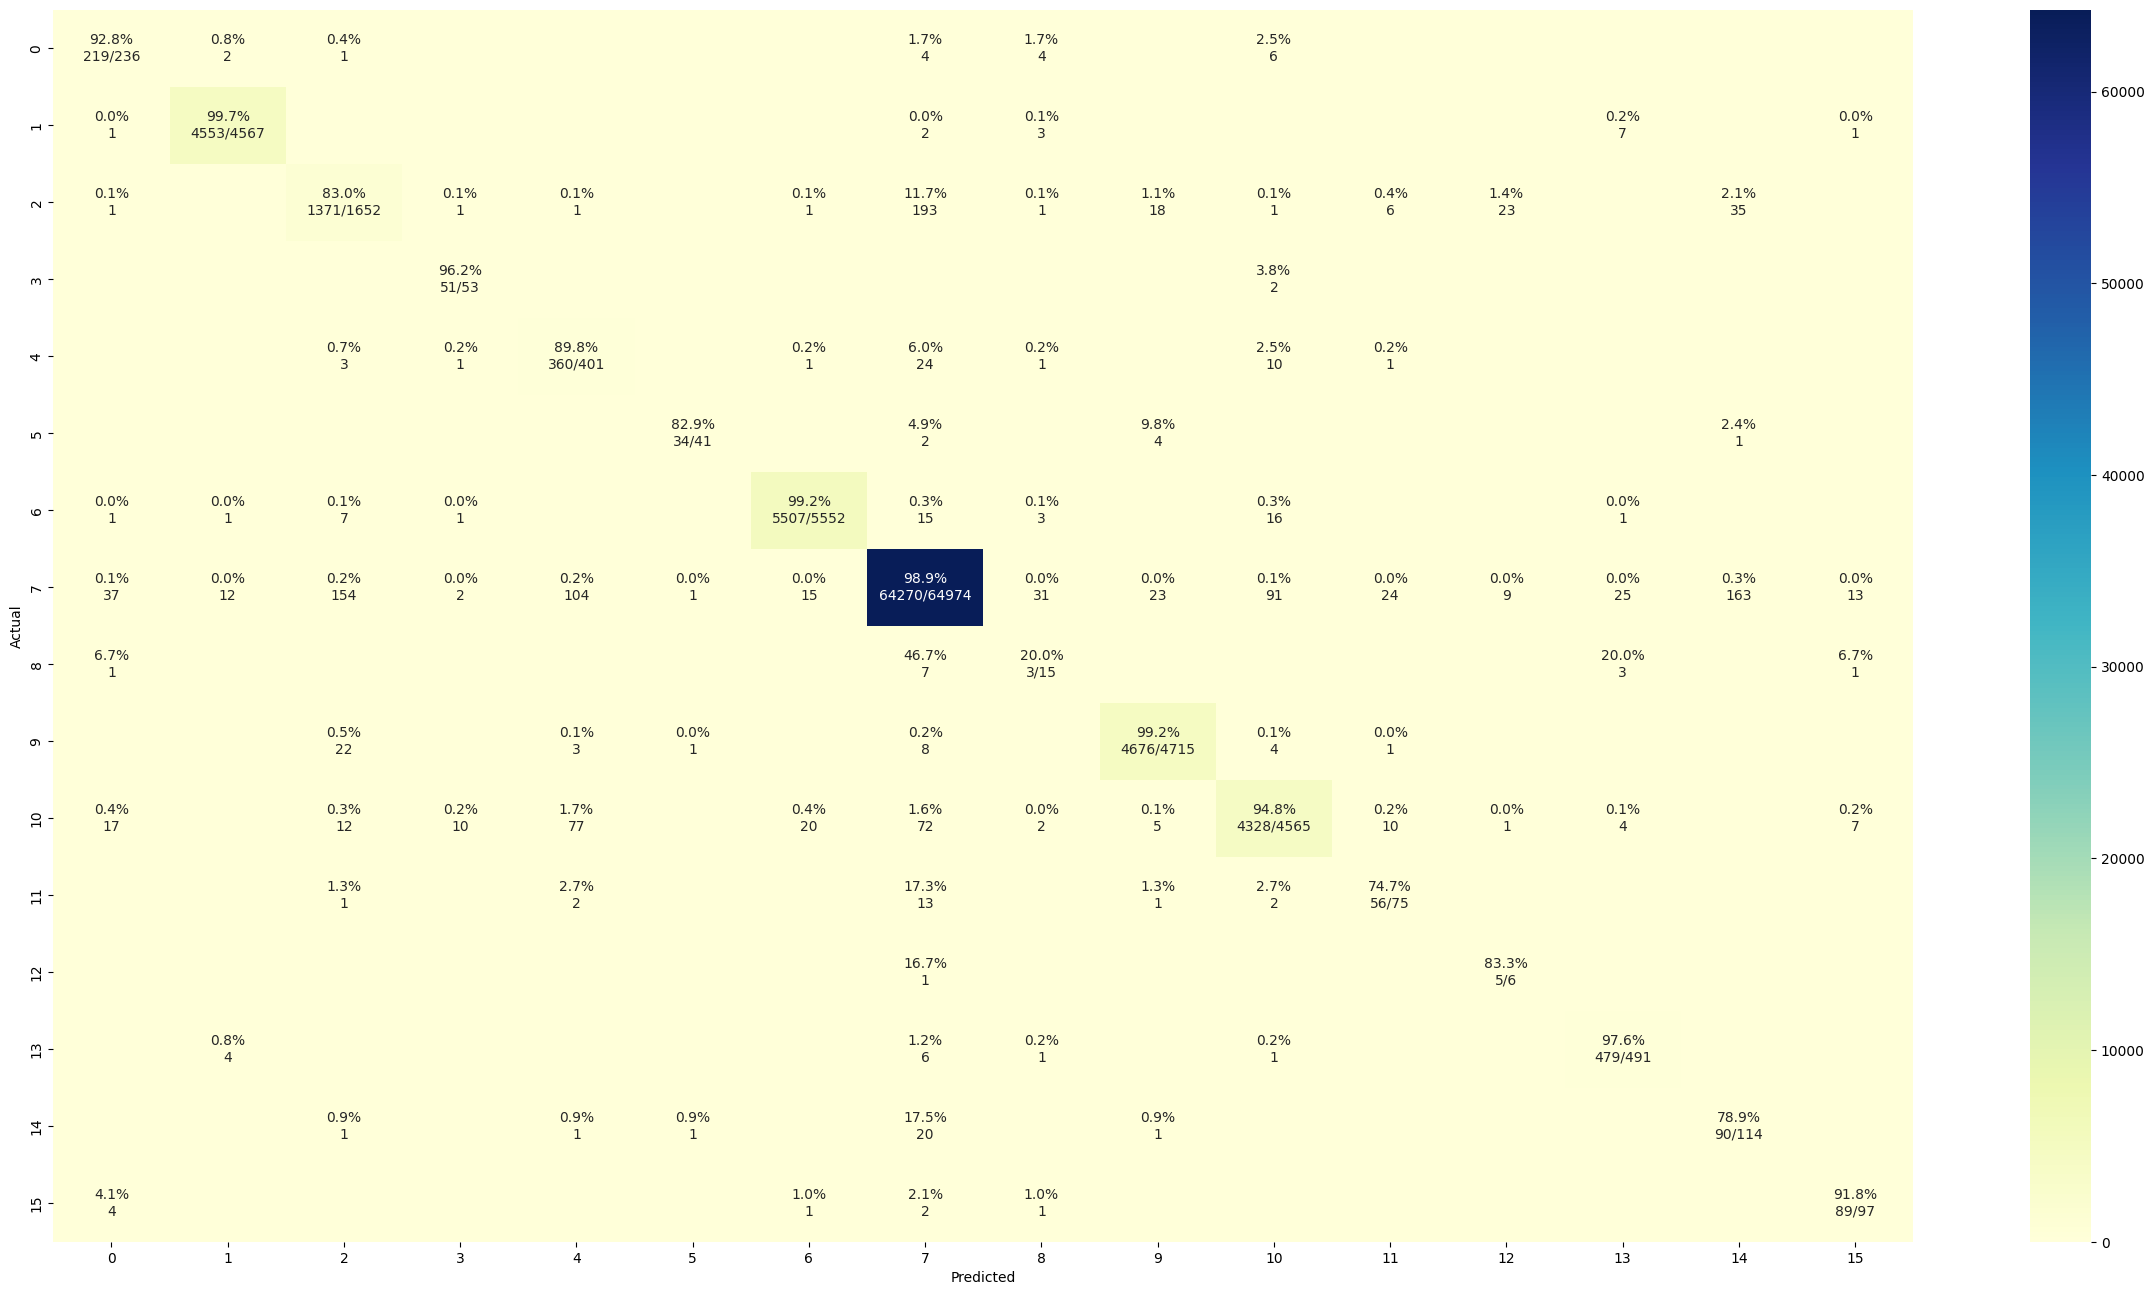

In [ ]:
plot_cm(y_test,y_pred7)

In [ ]:
print('Accuracy: %.5f' % accuracy_score(y_test, y_pred7))

Accuracy: 0.98329


In [ ]:
print('F1 Score: %.5f' % f1_score(y_test, y_pred7, average='weighted'))


F1 Score: 0.98437


In [ ]:
print('Recall: %.5f' % recall_score(y_test, y_pred7, average='weighted'))

Recall: 0.98329


In [ ]:
print('Precision: %.5f' % precision_score(y_test, y_pred7, average='weighted'))


Precision: 0.98608


## SGD, ReLu

In [ ]:
opt = SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
model8= Sequential()

model8.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu',input_shape=(216,1)))
model8.add(MaxPooling1D(pool_size=1))
model8.add(BatchNormalization())

model8.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'))
model8.add(MaxPooling1D(pool_size=1))
model8.add(Dropout(0.25))
model8.add(BatchNormalization())

model8.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='relu'))
model8.add(MaxPooling1D(pool_size=2))
model8.add(BatchNormalization())


model8.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='relu'))
model8.add(MaxPooling1D(pool_size=2))
model8.add(Dropout(0.25))
model8.add(BatchNormalization())

model8.add(Flatten())

model8.add(Dense(128,activation='relu'))
model8.add(Dropout(0.10))
model8.add(Dense(64,activation='relu'))
model8.add(Dropout(0.10))
model8.add(Dense(16,activation='softmax'))
model8.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model8.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 216, 256)          1024      
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 216, 256)         0         
 g1D)                                                            
                                                                 
 batch_normalization_32 (Bat  (None, 216, 256)         1024      
 chNormalization)                                                
                                                                 
 conv1d_33 (Conv1D)          (None, 216, 128)          98432     
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 216, 128)         0         
 g1D)                                                            
                                                      

In [ ]:
checkpoint_path = 'relu_sgd.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
history8 = model8.fit(X_train2, y, 
                    epochs=100, 
                    batch_size=128, class_weight = new_dic, callbacks =[checkpoint_callback])

Epoch 1/100
175/177 [============================>.] - ETA: 0s - loss: 3.1182 - accuracy: 0.5387
Epoch 1: accuracy improved from -inf to 0.53924, saving model to relu_sgd.h5
177/177 [==============================] - 7s 25ms/step - loss: 3.1104 - accuracy: 0.5392
Epoch 2/100
177/177 [==============================] - ETA: 0s - loss: 1.8709 - accuracy: 0.7187
Epoch 2: accuracy improved from 0.53924 to 0.71873, saving model to relu_sgd.h5
177/177 [==============================] - 5s 26ms/step - loss: 1.8709 - accuracy: 0.7187
Epoch 3/100
176/177 [============================>.] - ETA: 0s - loss: 1.4577 - accuracy: 0.7852
Epoch 3: accuracy improved from 0.71873 to 0.78515, saving model to relu_sgd.h5
177/177 [==============================] - 4s 25ms/step - loss: 1.4568 - accuracy: 0.7851
Epoch 4/100
175/177 [============================>.] - ETA: 0s - loss: 1.2502 - accuracy: 0.8055
Epoch 4: accuracy improved from 0.78515 to 0.80522, saving model to relu_sgd.h5
177/177 [================

In [ ]:
model8.load_weights(checkpoint_path)

In [ ]:
y_pred8 = np.argmax(model8.predict(X_test2),axis=-1)

2737/2737 [==============================] - 7s 3ms/step


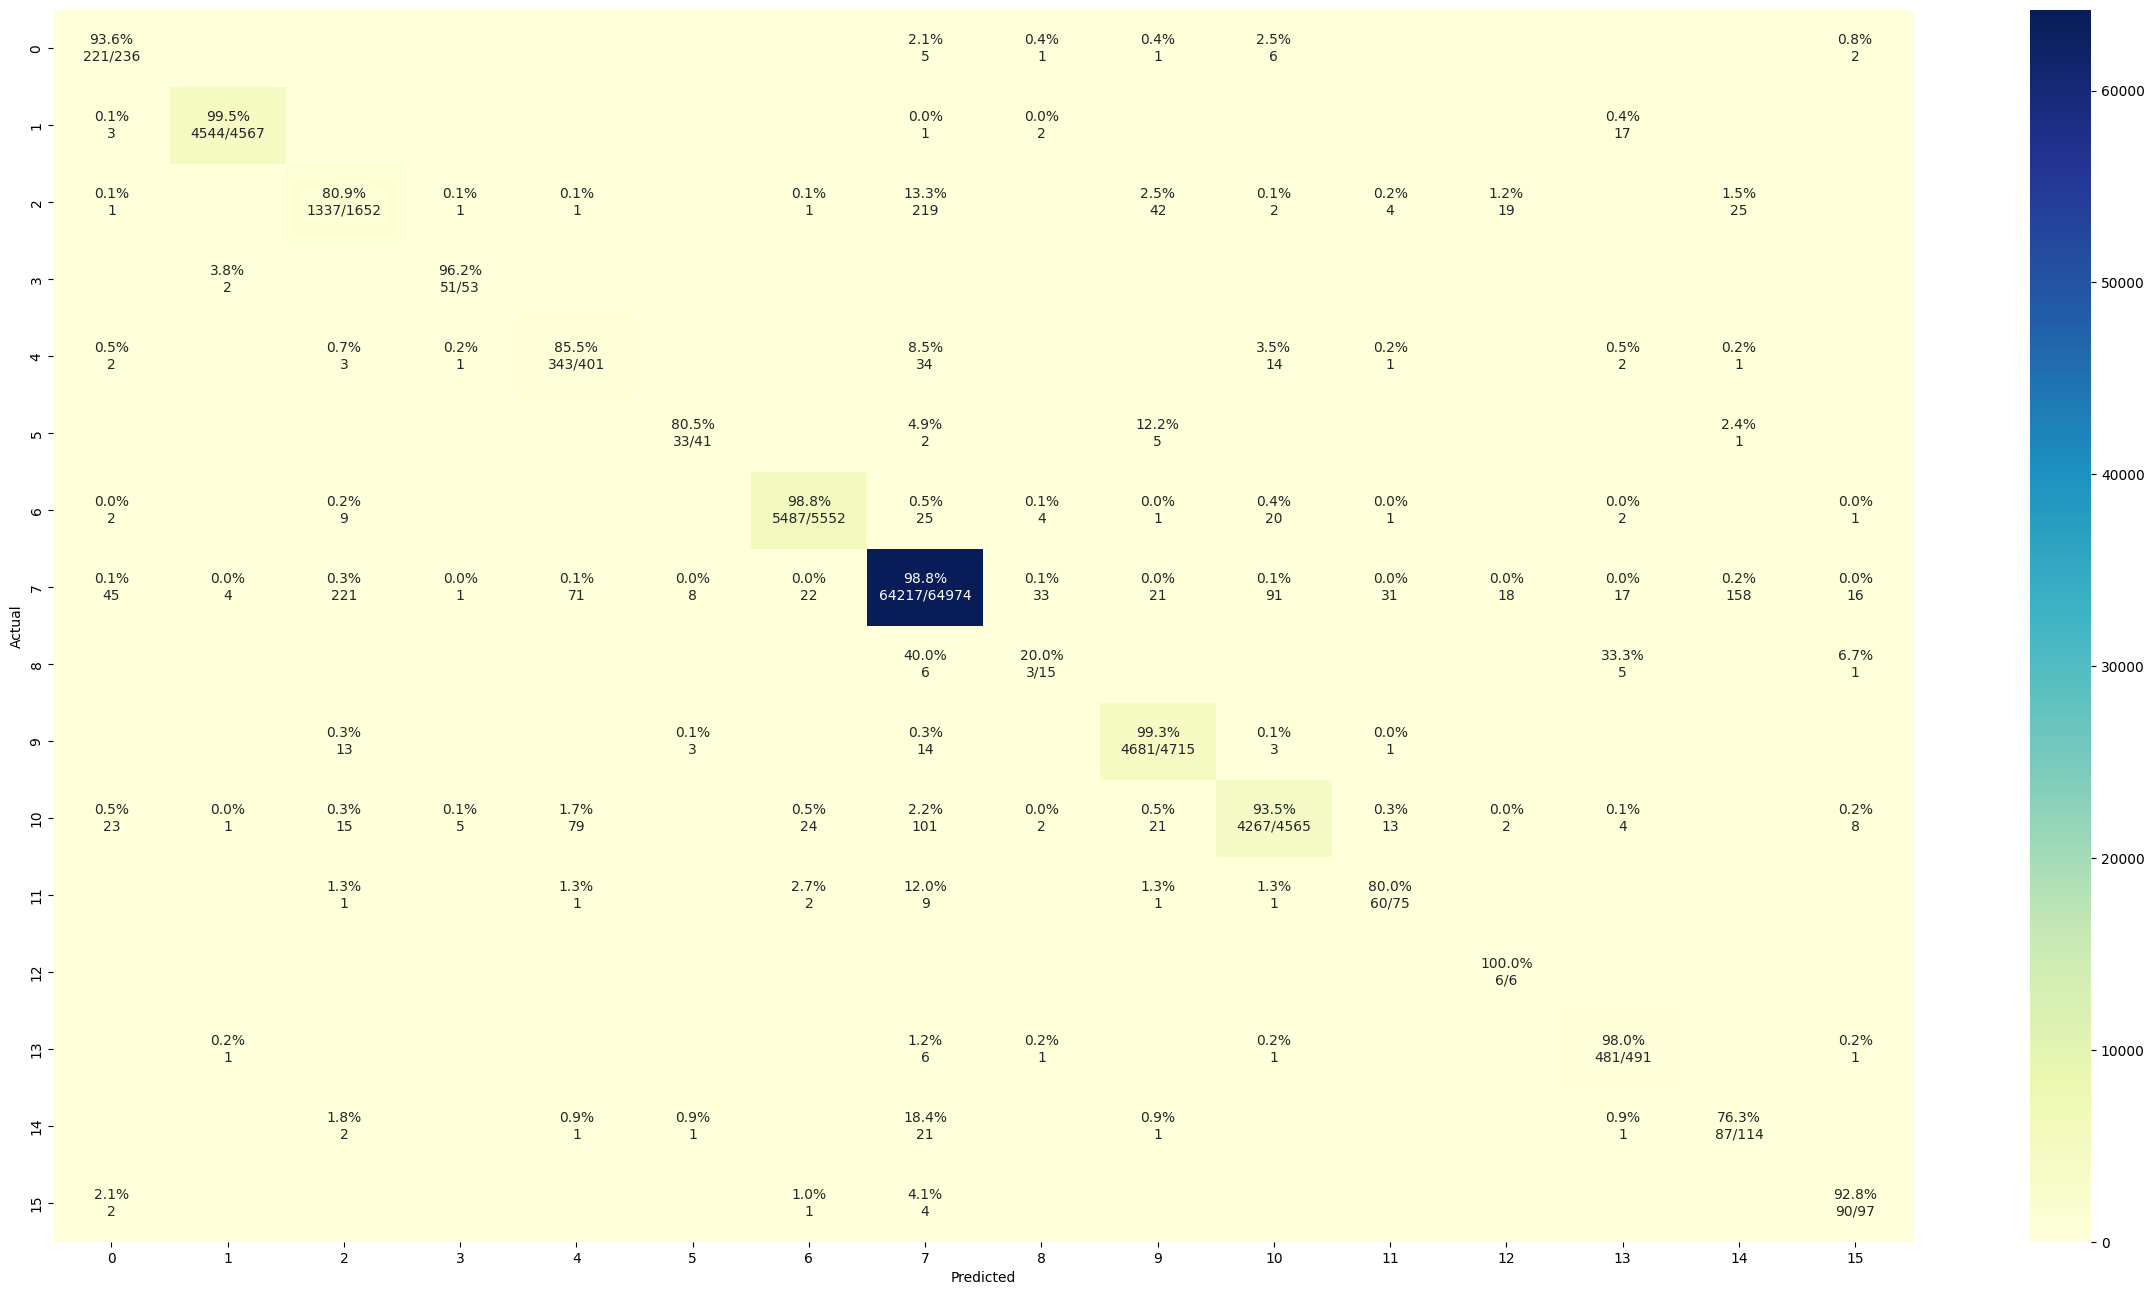

In [ ]:
plot_cm(y_test,y_pred8)

In [ ]:
print('Accuracy: %.5f' % accuracy_score(y_test, y_pred8))

Accuracy: 0.98120


In [ ]:
print('F1 Score: %.5f' % f1_score(y_test, y_pred8, average='weighted'))


F1 Score: 0.98222


In [ ]:
print('Recall: %.5f' % recall_score(y_test, y_pred8, average='weighted'))

Recall: 0.98120


In [ ]:
print('Precision: %.5f' % precision_score(y_test, y_pred8, average='weighted'))


Precision: 0.98381


## SGD, Mish

In [ ]:
opt = SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
model9= Sequential()

model9.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='Mish',input_shape=(216,1)))
model9.add(MaxPooling1D(pool_size=1))
model9.add(BatchNormalization())

model9.add(Conv1D(128,kernel_size=3,strides=1,padding='same',activation='Mish'))
model9.add(MaxPooling1D(pool_size=1))
model9.add(Dropout(0.25))
model9.add(BatchNormalization())

model9.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='Mish'))
model9.add(MaxPooling1D(pool_size=2))
model9.add(BatchNormalization())


model9.add(Conv1D(32,kernel_size=5,strides=1,padding='same',activation='Mish'))
model9.add(MaxPooling1D(pool_size=2))
model9.add(Dropout(0.25))
model9.add(BatchNormalization())

model9.add(Flatten())

model9.add(Dense(128,activation='Mish'))
model9.add(Dropout(0.10))
model9.add(Dense(64,activation='Mish'))
model9.add(Dropout(0.10))
model9.add(Dense(16,activation='softmax'))
model9.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model9.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 216, 256)          1024      
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 216, 256)         0         
 g1D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 216, 256)         1024      
 chNormalization)                                                
                                                                 
 conv1d_37 (Conv1D)          (None, 216, 128)          98432     
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 216, 128)         0         
 g1D)                                                            
                                                      

In [ ]:
checkpoint_path = 'mish_sgd.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
history9 = model9.fit(X_train2, y, 
                    epochs=100, 
                    batch_size=128, class_weight = new_dic,callbacks =[checkpoint_callback] )

Epoch 1/100
175/177 [============================>.] - ETA: 0s - loss: 2.8856 - accuracy: 0.5642
Epoch 1: accuracy improved from -inf to 0.56507, saving model to mish_sgd.h5
177/177 [==============================] - 8s 30ms/step - loss: 2.8900 - accuracy: 0.5651
Epoch 2/100
175/177 [============================>.] - ETA: 0s - loss: 1.8355 - accuracy: 0.7284
Epoch 2: accuracy improved from 0.56507 to 0.72848, saving model to mish_sgd.h5
177/177 [==============================] - 5s 30ms/step - loss: 1.8372 - accuracy: 0.7285
Epoch 3/100
175/177 [============================>.] - ETA: 0s - loss: 1.3390 - accuracy: 0.7910
Epoch 3: accuracy improved from 0.72848 to 0.79109, saving model to mish_sgd.h5
177/177 [==============================] - 5s 30ms/step - loss: 1.3354 - accuracy: 0.7911
Epoch 4/100
175/177 [============================>.] - ETA: 0s - loss: 1.1680 - accuracy: 0.8234
Epoch 4: accuracy improved from 0.79109 to 0.82370, saving model to mish_sgd.h5
177/177 [================

In [ ]:
model9.load_weights(checkpoint_path)

In [ ]:
y_pred9 = np.argmax(model9.predict(X_test2),axis=-1)

2737/2737 [==============================] - 10s 3ms/step


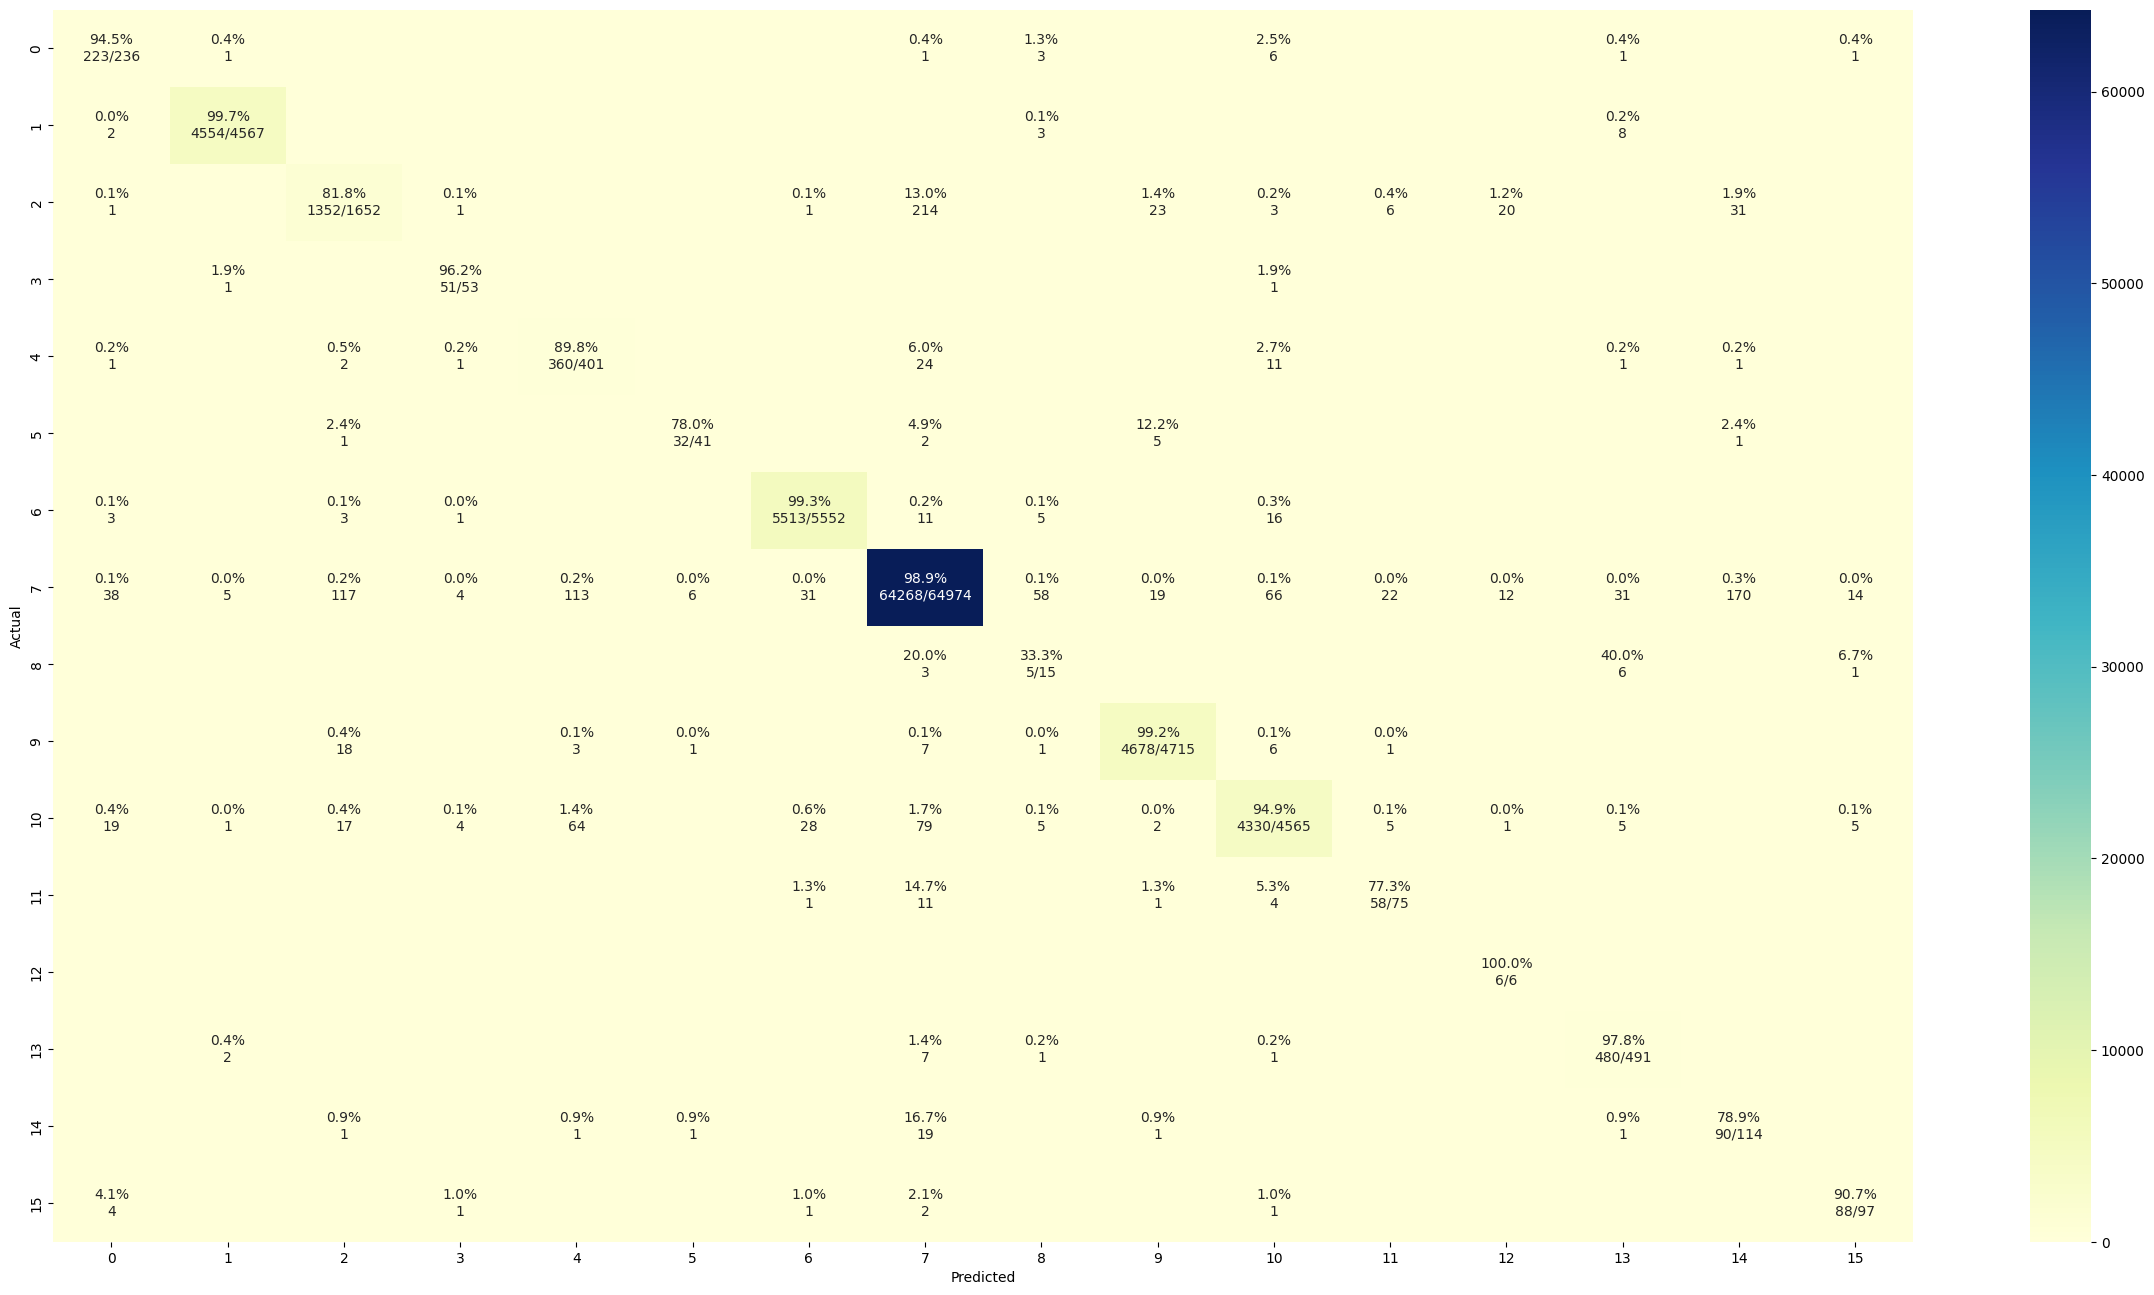

In [ ]:
plot_cm(y_test,y_pred9)

In [ ]:
print('Accuracy: %.5f' % accuracy_score(y_test, y_pred9))

Accuracy: 0.98326


In [ ]:

print('F1 Score: %.5f' % f1_score(y_test, y_pred9, average='weighted'))


F1 Score: 0.98444


In [ ]:
print('Recall: %.5f' % recall_score(y_test, y_pred9, average='weighted'))

Recall: 0.98326


In [ ]:
print('Precision: %.5f' % precision_score(y_test, y_pred9, average='weighted'))


Precision: 0.98632


# Final Result


In [ ]:
!pip install prettytable

In [ ]:
from prettytable import PrettyTable
import glob
# Create a new table object
table_ = PrettyTable()

# Add column headers
table_.field_names = ["Optimizer",
"Activation Function",
"Accuracy",
"F1 Score",
"Recall",
"Precision",
]



In [ ]:
models = glob.glob("/content/model_ckp/*.h5")

In [ ]:
for i in range(len(models)):
  y_pred = np.argmax(eval('model{}'.format(i+1)).predict(X_test2),axis=-1)
  activation_func = models[i].split('.')[0].split('/')[-1].split('_')[0]
  optimsier =  models[i].split('.')[0].split('/')[-1].split('_')[1]
  acc = accuracy_score(y_test, y_pred).round(5)*100
  f1 = f1_score(y_test, y_pred, average='weighted').round(5)*100
  rec = recall_score(y_test, y_pred, average='weighted').round(5)*100
  prec = precision_score(y_test, y_pred, average='weighted').round(5)*100
  table_.add_row([optimsier,activation_func, acc, f1, rec, prec])

2737/2737 [==============================] - 8s 3ms/step


In [ ]:
print(table_)

+-----------+---------------------+-------------------+-------------------+-------------------+-------------------+
| Optimizer | Activation Function |      Accuracy     |      F1 Score     |       Recall      |     Precision     |
+-----------+---------------------+-------------------+-------------------+-------------------+-------------------+
|    adam   |        swish        |       98.494      |       98.556      |       98.494      |       98.675      |
|    adam   |         mish        |       97.92       | 98.14500000000001 |       97.92       |       98.464      |
|   nadam   |         relu        |       97.992      | 98.03500000000001 |       97.992      |       98.142      |
|    sgd    |         relu        |       98.312      | 98.41499999999999 |       98.312      |       98.592      |
|   nadam   |        swish        |       97.76       |       97.896      |       97.76       |       98.107      |
|    sgd    |        swish        |       98.261      |       98.356    